### 1. Libraries Import

In [1]:
import os, json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.datasets import make_regression
sns.set()
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
import statsmodels.api as sm

### 2. Data Import

In [2]:
datadir = "../data"
outdir = "../output_reports"
outdir_graph = "../figures"
data = os.path.join(datadir, "NSDUH_2023_Tab.txt")

variables_used = [
    # Survey design variables 
    "ANALWT2_C", "VESTR_C", "VEREP",
    # Primary outcomes
    "SUTRTPY", "MHTRTPY",
    # Secondary (telehealth) outcomes
    "TELEAPTYR", "IRSUTPHVID", "IRMHTPHVID",
    # Demographic predictors
    "AGE3", "IRSEX", "NEWRACE2",
    # Socioeconomic predictors
    "IRMARIT", "IREDUHIGHST2", "IRWRKSTAT18",
    "IRINSUR4", "INCOME", "POVERTY3",
    # Clinical severity predictors
    "IRPYUD5ALC", "IRPYUD5MRJ", "KSSLR6YR", "IRAMDEYR",
    # Behavioral predictors
    "IRALCFY", "IRMJFY", "ILLYR",
    # Risk perception predictors
    "RSKCIGPKD", "RSKMRJWK"
]

df_og = pd.read_csv(data, sep = "\t", usecols = variables_used, dtype=str)

#export_path = os.path.join(datadir, "NSDUH_2023_subset_raw.csv")
#df_og.to_csv(export_path, index=False)

### 3. Data Cleaning & Remapping

In [ ]:
# Simple yes/no in 0/1 form
binary_map_01 = {"0": "No", "1": "Yes"}

# Age (AGE3)
age_map = {
    "1": "12–13",
    "2": "14–15",
    "3": "16–17",
    "4": "18–20",
    "5": "21–23",
    "6": "24–25",
    "7": "26–29",
    "8": "30–34",
    "9": "35–49",
    "10": "50–64",
    "11": "65+"
}

# Sex at birth (IRSEX)
sex_map = {"1":"Male","2":"Female"}

race_map = {
    "1": "Non-Hispanic White",
    "2": "Non-Hispanic Black/African American",
    "3": "Non-Hispanic Native American/Alaska Native",
    "4": "Non-Hispanic Native Hawaiian/Other Pacific Islander",
    "5": "Non-Hispanic Asian",
    "6": "Non-Hispanic more than one race",
    "7": "Hispanic"
}

# Family income (INCOME)
income_map = {
    "1":"< $20,000",
    "2":"$20,000-$49,999",
    "3":"$50,000-$74,999",
    "4":"$75,000+"
}

In [3]:
# Simple yes/no in 0/1 form
binary_map_01 = {"0": "No", "1": "Yes"}

# Age (AGE3)
age_map = {
    "1": "12-13",
    "2": "14-15",
    "3": "16-17",
    "4": "18-20",
    "5": "21-23",
    "6": "24-25",
    "7": "26-29",
    "8": "30-34",
    "9": "35-49",
    "10": "50-64",
    "11": "65+"
}

# Sex at birth (IRSEX)
sex_map = {"1":"Male","2":"Female"}

race_map = {
    "1": "Non-Hispanic White",
    "2": "Non-Hispanic Black/African American",
    "3": "Non-Hispanic Native American/Alaska Native",
    "4": "Non-Hispanic Native Hawaiian/Other Pacific Islander",
    "5": "Non-Hispanic Asian",
    "6": "Non-Hispanic more than one race",
    "7": "Hispanic"
}

# Family income (INCOME)
income_map = {
    "1":"< $20,000",
    "2":"$20,000-$49,999",
    "3":"$50,000-$74,999",
    "4":"$75,000+"
}

df = df_og.copy()

# Convert survey design variables to numeric
df["ANALWT2_C"] = pd.to_numeric(df["ANALWT2_C"], errors="coerce")
df["VESTR_C"]   = pd.to_numeric(df["VESTR_C"], errors="coerce")
df["VEREP"]     = pd.to_numeric(df["VEREP"], errors="coerce")

df["SUTRTPY_lbl"] = df["SUTRTPY"].map(binary_map_01)
# Convert to numeric for modeling
df["SUTRTPY"] = pd.to_numeric(df["SUTRTPY"], errors="coerce")

df["MHTRTPY_lbl"] = df["MHTRTPY"].map(binary_map_01)
# Convert to numeric for modeling
df["MHTRTPY"] = pd.to_numeric(df["MHTRTPY"], errors="coerce")

# Create a labeled version
df["TELEAPTYR_lbl"] = df["TELEAPTYR"].map({
    "1": "Yes",
    "2": "No",
    "85": "Bad data",
    "94": "Don't know",
    "97": "Refused",
    "98": "Blank"
})

# Convert to numeric (1 = Yes, 0 = No, NaN for all nonresponse codes)
df["TELEAPTYR"] = df["TELEAPTYR"].replace({
    "1": 1,
    "2": 0,
    "85": np.nan,
    "94": np.nan,
    "97": np.nan,
    "98": np.nan
}).astype("float")

df["IRSUTPHVID_lbl"] = df["IRSUTPHVID"].map(binary_map_01)
df["IRSUTPHVID"] = pd.to_numeric(df["IRSUTPHVID"], errors="coerce")

df["IRMHTPHVID_lbl"] = df["IRMHTPHVID"].map(binary_map_01)
df["IRMHTPHVID"] = pd.to_numeric(df["IRMHTPHVID"], errors="coerce")

df["AGE3_lbl"] = df["AGE3"].map(age_map)
df["AGE3"] = pd.to_numeric(df["AGE3"], errors="coerce")

df["IRSEX_lbl"] = df["IRSEX"].map(sex_map)
df["IRSEX"] = pd.to_numeric(df["IRSEX"], errors="coerce")

df["NEWRACE2_lbl"] = df["NEWRACE2"].map(race_map)
df["NEWRACE2"] = pd.to_numeric(df["NEWRACE2"], errors="coerce")

# Create a labeled version
df["IRMARIT_lbl"] = df["IRMARIT"].map({
    "1": "Married",
    "2": "Widowed",
    "3": "Divorced or Separated",
    "4": "Never Been Married",
    "99": "Legitimate skip (<=14 years old)"
})

# Convert to numeric, set skip to NaN
df["IRMARIT"] = df["IRMARIT"].replace({
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4,
    "99": np.nan
}).astype("float")

# Create a labeled version
df["IREDUHIGHST2_lbl"] = df["IREDUHIGHST2"].map({
    "1": "Fifth grade or less",
    "2": "Sixth grade",
    "3": "Seventh grade",
    "4": "Eighth grade",
    "5": "Ninth grade",
    "6": "Tenth grade",
    "7": "Eleventh or Twelfth grade, no diploma",
    "8": "High school diploma/GED",
    "9": "Some college credit, no degree",
    "10": "Associate's degree (AA, AS)",
    "11": "College graduate or higher"
})

# Convert to numeric (ordinal: 1–11)
df["IREDUHIGHST2"] = pd.to_numeric(df["IREDUHIGHST2"], errors="coerce")

# Create a labeled version
df["IRWRKSTAT18_lbl"] = df["IRWRKSTAT18"].map({
    "1": "Employed full time",
    "2": "Employed part time",
    "3": "Unemployed",
    "4": "Other (not in labor force)",
    "99": "Legitimate skip (age 12–14)"
})

# Convert to numeric (1–4), recode 99 to NaN
df["IRWRKSTAT18"] = df["IRWRKSTAT18"].replace({
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4,
    "99": np.nan
}).astype("float")

df["IRINSUR4_lbl"] = df["IRINSUR4"].map({
    "1": "Yes, covered by health insurance",
    "2": "No, not covered by health insurance"
})

# Convert to numeric (1 = Yes, 0 = No)
df["IRINSUR4"] = df["IRINSUR4"].replace({
    "1": 1,
    "2": 0
}).astype("float")

df["INCOME_lbl"] = df["INCOME"].map(income_map)
df["INCOME"] = pd.to_numeric(df["INCOME"], errors="coerce")

# Create a labeled version
df["POVERTY3_lbl"] = df["POVERTY3"].map({
    "1": "Living in Poverty",
    "2": "Income up to 2× Federal Poverty Threshold",
    "3": "Income more than 2× Federal Poverty Threshold",
    ".": "Persons Aged 18-22 in a College Dorm"
})

# Convert to numeric (1–3), set '.' (college dorm) to NaN
df["POVERTY3"] = df["POVERTY3"].replace({
    "1": 1,
    "2": 2,
    "3": 3,
    ".": np.nan
}).astype("float")

df["IRPYUD5ALC_lbl"] = df["IRPYUD5ALC"].map(binary_map_01)
df["IRPYUD5ALC"] = pd.to_numeric(df["IRPYUD5ALC"], errors="coerce")

df["IRPYUD5MRJ_lbl"] = df["IRPYUD5MRJ"].map(binary_map_01)
df["IRPYUD5MRJ"] = pd.to_numeric(df["IRPYUD5MRJ"], errors="coerce")

df["KSSLR6YR"] = pd.to_numeric(df["KSSLR6YR"], errors="coerce")
# Ensure values outside 0–24 are treated as missing (paranoid safety)
df.loc[~df["KSSLR6YR"].between(0, 24, inclusive="both"), "KSSLR6YR"] = np.nan

df["IRAMDEYR_lbl"] = df["IRAMDEYR"].map({
    "0": "No",
    "1": "Yes",
    ".": "Not applicable (aged 12–17)"
})

# Convert to numeric (1 = Yes, 0 = No, NaN = not applicable)
df["IRAMDEYR"] = df["IRAMDEYR"].replace({
    "0": 0,
    "1": 1,
    ".": np.nan
}).astype("float")

# Create a labeled version
df["IRALCFY_lbl"] = df["IRALCFY"].map({
    "991": "Never used alcohol",
    "993": "No past-year use"
})

# Convert to numeric, treating 991 and 993 as 0 (no use), others keep their day counts
df["IRALCFY"] = df["IRALCFY"].replace({
    "991": 0,
    "993": 0
})
df["IRALCFY"] = pd.to_numeric(df["IRALCFY"], errors="coerce")

# Create a labeled version
df["IRMJFY_lbl"] = df["IRMJFY"].map({
    "991": "Never used marijuana",
    "993": "No past-year use"
})

# Convert to numeric, treating 991 and 993 as 0 (no use), others keep their day counts
df["IRMJFY"] = df["IRMJFY"].replace({
    "991": 0,
    "993": 0
})
df["IRMJFY"] = pd.to_numeric(df["IRMJFY"], errors="coerce")

# Create a labeled version
df["ILLYR_lbl"] = df["ILLYR"].map({
    "0": "Did not use in past year",
    "1": "Used in past year"
})

# Convert to numeric (binary: 0/1)
df["ILLYR"] = df["ILLYR"].replace({
    "0": 0,
    "1": 1
}).astype("float")

# Create a labeled version
df["RSKCIGPKD_lbl"] = df["RSKCIGPKD"].map({
    "1": "No risk",
    "2": "Slight risk",
    "3": "Moderate risk",
    "4": "Great risk",
    "85": "Bad data",
    "94": "Don't know",
    "97": "Refused",
    "98": "Blank"
})

# Convert to numeric (ordinal 1–4), set nonresponse codes to NaN
df["RSKCIGPKD"] = df["RSKCIGPKD"].replace({
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4,
    "85": np.nan,
    "94": np.nan,
    "97": np.nan,
    "98": np.nan
}).astype("float")

# Create a labeled version
df["RSKMRJWK_lbl"] = df["RSKMRJWK"].map({
    "1": "No risk",
    "2": "Slight risk",
    "3": "Moderate risk",
    "4": "Great risk",
    "85": "Bad data",
    "94": "Don't know",
    "97": "Refused",
    "98": "Blank"
})

# Convert to numeric (ordinal 1–4), set nonresponse codes to NaN
df["RSKMRJWK"] = df["RSKMRJWK"].replace({
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4,
    "85": np.nan,
    "94": np.nan,
    "97": np.nan,
    "98": np.nan
}).astype("float")

C:\Users\Admin\AppData\Local\Temp\ipykernel_49624\2201229861.py:66: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["TELEAPTYR"] = df["TELEAPTYR"].replace({
C:\Users\Admin\AppData\Local\Temp\ipykernel_49624\2201229861.py:100: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["IRMARIT"] = df["IRMARIT"].replace({
C:\Users\Admin\AppData\Local\Temp\ipykernel_49624\2201229861.py:136: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `resul

### 4. Data Analysis

#### 4.1. LASSO Logistic Regression Model for SUTRTPY

In [85]:
target = "SUTRTPY"
weight = "ANALWT2_C"

# Numeric (continuous count/score) features
numeric_cols = ["IRALCFY", "IRMJFY", "KSSLR6YR"]

# Treat coded fields as categorical (one-hot)
categorical_cols = [
    "AGE3","IRSEX","NEWRACE2",
    "IRMARIT","IREDUHIGHST2","IRWRKSTAT18",
    "IRINSUR4","INCOME","POVERTY3",
    "IRPYUD5ALC","IRPYUD5MRJ","ILLYR",
    "RSKCIGPKD","RSKMRJWK"
]

# Keep rows with target and weight
work = df.loc[df[target].notna() & df[weight].notna()].copy()
work["w_norm"] = work[weight] / work[weight].mean()

X = work[categorical_cols + numeric_cols]
y = work[target].astype(int).to_numpy().ravel()
w = work["w_norm"].astype(float).to_numpy().ravel()

# Train / test split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w, test_size=0.25, random_state=123, stratify=y
)

# Preprocess (impute+encode categoricals, impute+scale numerics)
pre = ColumnTransformer(
    transformers=[
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True, drop="if_binary"))
        ]), categorical_cols),
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler(with_mean=False))  # keep sparse compatibility
        ]), numeric_cols),
    ],
    remainder="drop",
    sparse_threshold=1.0
)

# LASSO logistic (CV on C), weighted fit
C_grid = np.logspace(-3, 1, 12)

lasso_cv = LogisticRegressionCV(
    Cs=C_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=123),
    penalty="l1",
    solver="saga",
    scoring="roc_auc",
    max_iter=10000,
    n_jobs=-1,
    refit=True
)

pipe = Pipeline([
    ("pre", pre),
    ("clf", lasso_cv)
])

pipe.fit(X_train, y_train, clf__sample_weight=w_train)

# Evaluate
y_prob = pipe.predict_proba(X_test)[:, 1]
y_hat  = (y_prob >= 0.5).astype(int)
auc    = roc_auc_score(y_test, y_prob, sample_weight=w_test)
acc    = accuracy_score(y_test, y_hat, sample_weight=w_test)

print(f"AUC (weighted): {auc:.3f}")
print(f"Accuracy (weighted, thr=0.5): {acc:.3f}")

# Coefficients + selected features (non-zero)
ohe = pipe.named_steps["pre"].named_transformers_["cat"].named_steps["ohe"]
cat_names = list(ohe.get_feature_names_out(categorical_cols))
feature_names = cat_names + numeric_cols

coef = pipe.named_steps["clf"].coef_.ravel()
selected = [(name, float(wt)) for name, wt in zip(feature_names, coef) if wt != 0]

print(f"Selected features (non-zero): {len(selected)}")
for name, wt in sorted(selected, key=lambda x: abs(x[1]), reverse=True)[:40]:
    print(f"{wt:+.4f}  {name}")

# Metrics
y_prob = pipe.predict_proba(X_test)[:, 1]
y_hat  = (y_prob >= 0.5).astype(int)
auc    = roc_auc_score(y_test, y_prob, sample_weight=w_test)
acc    = accuracy_score(y_test, y_hat, sample_weight=w_test)

with open(os.path.join(outdir + "/SUTRTPY/lasso_output/", f"lasso_{target}_metrics.json"), "w") as f:
    json.dump({"AUC_weighted": float(auc),
               "Accuracy_weighted_thr0.5": float(acc)}, f, indent=2)

# Coefficients
ohe = pipe.named_steps["pre"].named_transformers_["cat"].named_steps["ohe"]
cat_names = list(ohe.get_feature_names_out(categorical_cols))
feature_names = cat_names + numeric_cols

coef = pipe.named_steps["clf"].coef_.ravel()
coef_df = pd.DataFrame({"feature": feature_names, "coef": coef})
coef_df = coef_df.loc[coef_df["coef"] != 0].copy()
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df.sort_values("abs_coef", ascending=False, inplace=True)

coef_df[["feature","coef"]].to_csv(
    os.path.join(outdir + "/SUTRTPY/lasso_output/", f"lasso_{target}_coefficients.csv"), index=False
)

AUC (weighted): 0.760
Accuracy (weighted, thr=0.5): 0.956
Selected features (non-zero): 48
+1.1466  IRPYUD5ALC_1.0
+1.0899  ILLYR_1.0
-0.7034  IRMARIT_1.0
+0.6934  AGE3_9.0
-0.6443  IREDUHIGHST2_11.0
+0.6273  IRPYUD5MRJ_1.0
+0.5861  IREDUHIGHST2_5.0
-0.5385  IREDUHIGHST2_10.0
+0.5232  NEWRACE2_4.0
+0.5215  IRINSUR4_1.0
+0.4421  AGE3_8.0
+0.4224  IREDUHIGHST2_3.0
-0.4094  AGE3_11.0
+0.3795  AGE3_10.0
-0.3629  IRWRKSTAT18_1.0
-0.3443  AGE3_5.0
-0.3382  AGE3_4.0
+0.2583  KSSLR6YR
-0.2570  IREDUHIGHST2_9.0
+0.2559  IREDUHIGHST2_6.0
-0.2529  RSKCIGPKD_3.0
-0.2450  IRMARIT_4.0
+0.2265  NEWRACE2_1.0
-0.2181  RSKCIGPKD_4.0
-0.2133  NEWRACE2_2.0
+0.1911  IREDUHIGHST2_4.0
+0.1888  NEWRACE2_3.0
-0.1840  NEWRACE2_5.0
-0.1804  RSKMRJWK_4.0
-0.1802  IRALCFY
-0.1688  IRMJFY
+0.1677  POVERTY3_1.0
+0.1395  INCOME_1.0
-0.1332  IREDUHIGHST2_8.0
-0.1152  IREDUHIGHST2_1.0
-0.0963  INCOME_4.0
+0.0864  IRWRKSTAT18_4.0
+0.0834  IRMARIT_2.0
-0.0716  AGE3_2.0
+0.0643  RSKMRJWK_1.0


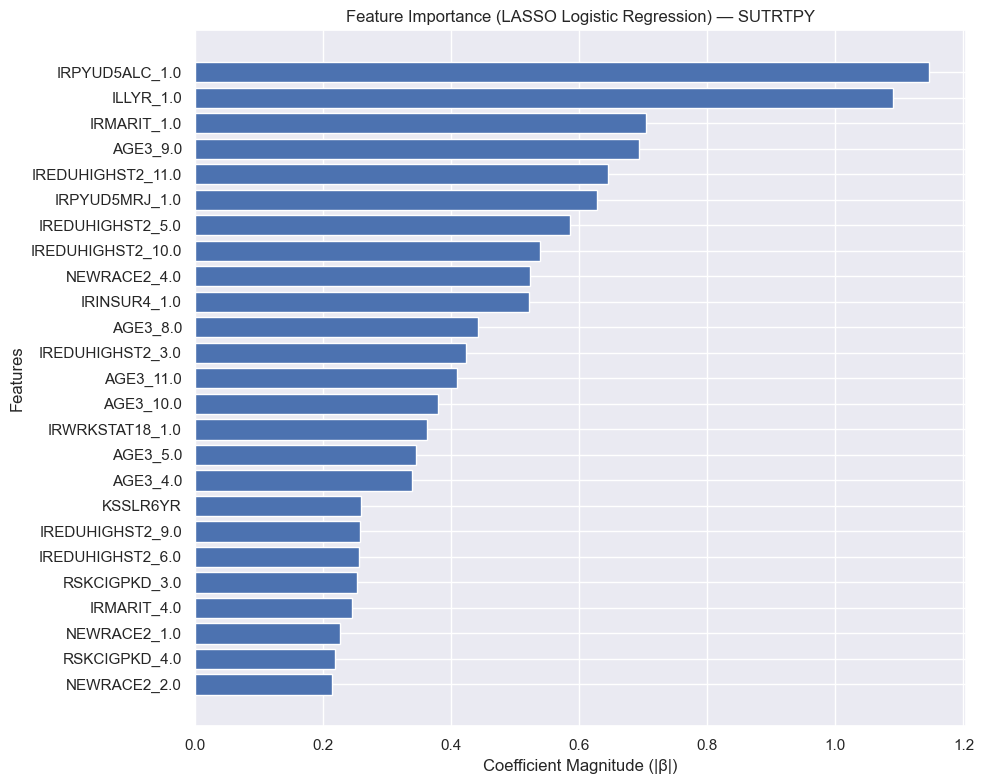

In [86]:
target = "SUTRTPY" 
outdir = "../output_reports"
coef_path = os.path.join(outdir + "/SUTRTPY/lasso_output/", f"lasso_{target}_coefficients.csv")
top_n = 25           # number of features to display

coef_df = pd.read_csv(coef_path)

# Clean and prepare
coef_df = coef_df.rename(columns={"feature": "Feature", "coef": "Coefficient"})
coef_df["AbsCoef"] = coef_df["Coefficient"].abs()

# Sort by absolute magnitude (descending)
coef_df = coef_df.sort_values(by="AbsCoef", ascending=False, ignore_index=True)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(coef_df["Feature"].head(top_n), coef_df["AbsCoef"].head(top_n))
plt.xlabel("Coefficient Magnitude (|β|)")
plt.ylabel("Features")
plt.title(f"Feature Importance (LASSO Logistic Regression) — {target}")
plt.gca().invert_yaxis()  # largest at the top
plt.tight_layout()

# Save and/or show
save_path = os.path.join(outdir_graph, f"lasso_{target}_feature_importance_from_export.png")
plt.savefig(save_path, dpi=200)
plt.show()

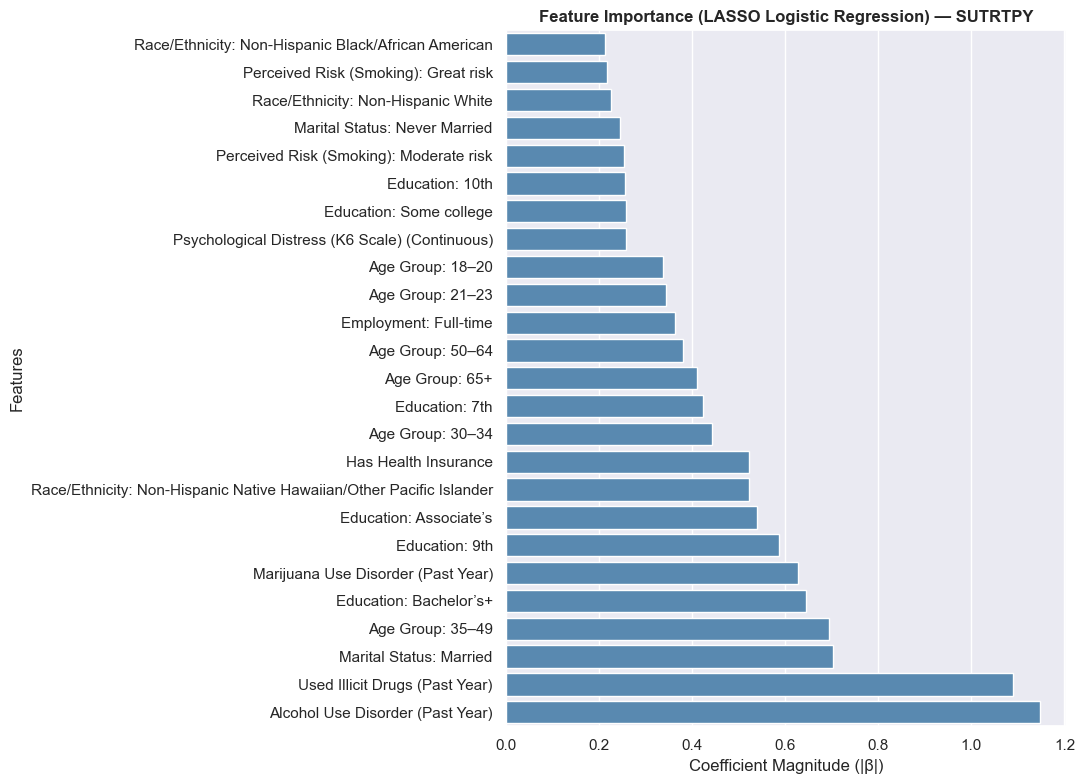

Saved: ../output_reports\SUTRTPY/lasso_output\lasso_SUTRTPY_feature_importance.png


In [5]:
# ====== Pretty label helper ======
# Uses your existing maps: age_map, sex_map, race_map, income_map
def prettify_feature_labels(feature_like):
    """
    Accepts a pandas Series (or index) of feature names like:
      'NEWRACE2_2.0', 'IRINSUR4_1.0', 'KSSLR6YR', 'const'
    Returns a list of human-readable labels for plotting.
    """
    # Local dictionaries for variables not already provided above
    marital_map = {"1":"Married","2":"Widowed","3":"Divorced/Separated","4":"Never Married"}
    edu_map = {
        "1":"≤5th grade","2":"6th","3":"7th","4":"8th","5":"9th","6":"10th",
        "7":"11–12 (no diploma)","8":"High school/GED","9":"Some college",
        "10":"Associate’s","11":"Bachelor’s+"
    }
    work_map = {"1":"Full-time","2":"Part-time","3":"Unemployed","4":"Not in labor force"}
    pov_map  = {"1":"Below poverty","2":"≤2× threshold","3":">2× threshold"}
    risk_map = {"1":"No risk","2":"Slight risk","3":"Moderate risk","4":"Great risk"}

    # Vars treated as continuous
    continuous_vars = {"KSSLR6YR", "IRALCFY", "IRMJFY"}

    # Binary “positive” phrasing for nicer labels
    binary_positive = {
        "IRINSUR4": "Has Health Insurance",
        "ILLYR": "Used Illicit Drugs (Past Year)",
        "IRPYUD5ALC": "Alcohol Use Disorder (Past Year)",
        "IRPYUD5MRJ": "Marijuana Use Disorder (Past Year)",
    }

    out = []
    for raw in list(feature_like):
        f = str(raw)

        if f == "const":
            out.append("Intercept")
            continue

        # Split base and level (for dummies)
        if "_" in f:
            base, lvl = f.split("_", 1)
            lvl = lvl.replace(".0", "")  # clean OneHot suffix
        else:
            base, lvl = f, None

        # Build human label
        if base in continuous_vars:
            # Continuous vars (no levels)
            base_label = {
                "KSSLR6YR": "Psychological Distress (K6 Scale)",
                "IRALCFY": "Alcohol Use Days (Past Year)",
                "IRMJFY": "Marijuana Use Days (Past Year)"
            }.get(base, base)
            label = f"{base_label} (Continuous)"

        elif base == "AGE3":
            label = f"Age Group: {age_map.get(lvl, lvl)}"
        elif base == "IRSEX":
            label = f"Sex: {sex_map.get(lvl, lvl)}"
        elif base == "NEWRACE2":
            label = f"Race/Ethnicity: {race_map.get(lvl, lvl)}"
        elif base == "INCOME":
            label = f"Income: {income_map.get(lvl, lvl)}"
        elif base == "IRMARIT":
            label = f"Marital Status: {marital_map.get(lvl, lvl)}"
        elif base == "IREDUHIGHST2":
            label = f"Education: {edu_map.get(lvl, lvl)}"
        elif base == "IRWRKSTAT18":
            label = f"Employment: {work_map.get(lvl, lvl)}"
        elif base == "POVERTY3":
            label = f"Poverty Status: {pov_map.get(lvl, lvl)}"
        elif base == "RSKCIGPKD":
            label = f"Perceived Risk (Smoking): {risk_map.get(lvl, lvl)}"
        elif base == "RSKMRJWK":
            label = f"Perceived Risk (Marijuana): {risk_map.get(lvl, lvl)}"
        elif base in binary_positive and lvl == "1":
            label = binary_positive[base]
        else:
            # Fallback to raw if we don't recognize it
            label = f

        out.append(label)

    return out

# ====== LASSO: plot from exported coefficients ======
def plot_lasso_from_export(target, outdir="../output_reports", top_n=25, color="#4B8BBE"):
    """
    Reads ../output_reports/{target}/lasso_output/lasso_{target}_coefficients.csv
    and plots top_n absolute coefficients with pretty labels.
    """
    coef_path = os.path.join(outdir, f"{target}/lasso_output", f"lasso_{target}_coefficients.csv")
    coef_df = pd.read_csv(coef_path).rename(columns={"feature":"Feature", "coef":"Coefficient"})
    coef_df["AbsCoef"] = coef_df["Coefficient"].abs()
    coef_df = coef_df.sort_values("AbsCoef", ascending=False).head(top_n).copy()

    # Pretty labels
    coef_df["PrettyLabel"] = prettify_feature_labels(coef_df["Feature"])

    # Plot
    plt.figure(figsize=(11, 8))
    sns.barplot(data=coef_df, y="PrettyLabel", x="AbsCoef", color=color)
    plt.xlabel("Coefficient Magnitude (|β|)")
    plt.ylabel("Features")
    plt.title(f"Feature Importance (LASSO Logistic Regression) — {target}", weight="bold")
    plt.gca().invert_yaxis()
    plt.tight_layout()

    # Save next to export
    out_png = os.path.join(outdir, f"{target}/lasso_output", f"lasso_{target}_feature_importance.png")
    plt.savefig(out_png, dpi=220)
    plt.show()
    print("Saved:", out_png)

# ====== GLM: odds ratio forest plot from exported OR table ======
def plot_glm_forest_from_export(target, outdir="../output_reports", top_n=25, color="#3565A1"):
    """
    Reads ../output_reports/{target}/glm_output/glm_{target}_or_table.csv
    (expects columns like: term/feature/variable or index, plus OR, 2.5%, 97.5%, p-value)
    Plots top_n features by |log(OR)| with pretty labels on a log-OR forest.
    """
    or_path = os.path.join(outdir, f"{target}/glm_output", f"glm_{target}_or_table.csv")
    df = pd.read_csv(or_path)

    # ---- Robustly find the term column ----
    # Common possibilities for the term column (case-insensitive)
    candidates = [c for c in df.columns if c.lower() in {"term", "feature", "variable", "name", "predictor"}]
    if candidates:
        df = df.rename(columns={candidates[0]: "term"})
    elif "Unnamed: 0" in df.columns:
        df = df.rename(columns={"Unnamed: 0": "term"})
    else:
        # Try re-reading with index as the term
        df_idx = pd.read_csv(or_path, index_col=0)
        if len(df_idx.columns) >= 1:
            df = df_idx.reset_index().rename(columns={"index": "term"})
        else:
            raise ValueError("Couldn't find a 'term' column (or index) in the GLM OR table export.")

    # ---- Standardize numeric columns ----
    # Try to find OR and CI columns if they have minor naming variations
    col_map = {c.lower(): c for c in df.columns}
    def pick(*opts):
        for o in opts:
            if o in col_map: return col_map[o]
        raise ValueError(f"Missing expected column among: {opts}")

    or_col  = pick("or")
    lo_col  = pick("2.5%", "2_5", "ci_low", "lower", "lower_ci", "lcl")
    hi_col  = pick("97.5%", "97_5", "ci_high", "upper", "upper_ci", "ucl")

    # Keep only needed columns
    or_df = df.loc[:, ["term", or_col, lo_col, hi_col] + [c for c in df.columns if c.lower() == "p-value"]].copy()
    or_df = or_df.rename(columns={or_col: "OR", lo_col: "2.5%", hi_col: "97.5%"})

    # Drop intercept if present
    or_df = or_df[or_df["term"] != "const"].copy()

    # Ensure numeric and >0 for log
    for c in ["OR", "2.5%", "97.5%"]:
        or_df[c] = pd.to_numeric(or_df[c], errors="coerce").clip(lower=1e-12)

    # Sort by |log(OR)|
    or_df["abs_logOR"] = np.abs(np.log(or_df["OR"]))
    plot_df = or_df.sort_values("abs_logOR", ascending=False).head(top_n).copy()

    # Pretty labels
    plot_df["PrettyLabel"] = prettify_feature_labels(plot_df["term"])

    # ---- Plot (forest on log scale) ----
    plt.figure(figsize=(11, 9))
    y_pos = np.arange(len(plot_df))[::-1]
    x  = plot_df["OR"].values
    lo = plot_df["2.5%"].values
    hi = plot_df["97.5%"].values

    plt.hlines(y=y_pos, xmin=lo, xmax=hi, color=color, alpha=0.9)
    plt.scatter(x, y_pos, s=35, color=color)
    plt.axvline(1.0, color="gray", linestyle="--", linewidth=1)

    plt.yticks(y_pos, plot_df["PrettyLabel"])
    plt.xscale("log")
    plt.xlabel("Odds Ratio (OR) with 95% CI")
    plt.ylabel("Features")
    plt.title(f"GLM Odds Ratios — {target}", weight="bold")
    plt.tight_layout()

    out_png = os.path.join(outdir, f"{target}/glm_output", f"glm_{target}_forest.png")
    plt.savefig(out_png, dpi=220)
    plt.show()
    print("Saved:", out_png)

# ====== Random Forest: feature importance from export ======
def plot_rf_from_export(target, outdir="../output_reports", top_n=25, color="#2E8B57"):
    """
    Reads ../output_reports/{target}/rf_output/rf_{target}_feature_importance.csv
    (expects columns: feature, importance)
    Plots top_n importances with pretty labels.
    """
    rf_path = os.path.join(outdir, f"{target}/rf_output", f"rf_{target}_feature_importance.csv")
    rf_df = pd.read_csv(rf_path).rename(columns={"feature":"Feature", "importance":"Importance"})
    rf_df = rf_df.sort_values("Importance", ascending=False).head(top_n).copy()

    # Pretty labels
    rf_df["PrettyLabel"] = prettify_feature_labels(rf_df["Feature"])

    plt.figure(figsize=(11, 8))
    sns.barplot(data=rf_df, y="PrettyLabel", x="Importance", color=color)
    plt.xlabel("Feature Importance")
    plt.ylabel("Features")
    plt.title(f"Feature Importance (Random Forest) — {target}", weight="bold")
    plt.gca().invert_yaxis()
    plt.tight_layout()

    out_png = os.path.join(outdir, f"{target}/rf_output", f"rf_{target}_feature_importance.png")
    plt.savefig(out_png, dpi=220)
    plt.show()
    print("Saved:", out_png)

# ====== Example calls ======
# LASSO
plot_lasso_from_export(target="SUTRTPY", outdir="../output_reports", top_n=25)

In [7]:
import textwrap

# --- compact maps for categories (for plot labels only) ---
race_map_short = {
    "1": "NH White", "2": "NH Black", "3": "NH Native Am/AK",
    "4": "NH NH/OPI", "5": "NH Asian", "6": "NH ≥2 races", "7": "Hispanic"
}
edu_map_short = {
    "1":"≤5th", "2":"6th", "3":"7th", "4":"8th", "5":"9th", "6":"10th",
    "7":"11-12 (no dip.)", "8":"HS/GED", "9":"Some college",
    "10":"Associate’s", "11":"Bachelor’s+"
}
marital_map_short = {"1":"Married","2":"Widowed","3":"Divorced/Separated","4":"Never married"}
work_map_short    = {"1":"Full-time","2":"Part-time","3":"Unemployed","4":"Not in labor force"}
pov_map_short     = {"1":"Below poverty","2":"≤2× thresh.","3":">2× thresh."}
risk_map_short    = {"1":"No risk","2":"Slight","3":"Moderate","4":"Great"}
income_map_short  = {"1":"<$20k","2":"$20–49k","3":"$50–74k","4":"$75k+"}

binary_positive = {
    "IRINSUR4": "Has Health Insurance",
    "ILLYR": "Used Illicit Drugs (Past Year)",
    "IRPYUD5ALC": "Alcohol Use Disorder (Past Year)",
    "IRPYUD5MRJ": "Marijuana Use Disorder (Past Year)",
}

continuous_nice = {
    "KSSLR6YR": "Psychological Distress (K6)",
    "IRALCFY":  "Alcohol Use Days (PY)",
    "IRMJFY":   "Marijuana Use Days (PY)",
}

def wrap_text(s, width=26):
    return "\n".join(textwrap.wrap(s, width=width, break_long_words=False))

def pretty_label(raw_feature, wrap=26):
    f = str(raw_feature)
    if f == "const":
        return "Intercept"

    base, lvl = (f.split("_", 1) + [None])[:2]
    if lvl is not None:
        lvl = lvl.replace(".0", "")

    # continuous
    if base in continuous_nice:
        lab = f"{continuous_nice[base]} (cont.)"
    elif base == "AGE3":
        lab = f"Age Group: {age_map.get(lvl, lvl)}"
    elif base == "IRSEX":
        lab = f"Sex: {sex_map.get(lvl, lvl)}"
    elif base == "NEWRACE2":
        lab = f"Race/Ethnicity: {race_map_short.get(lvl, lvl)}"
    elif base == "INCOME":
        lab = f"Income: {income_map_short.get(lvl, lvl)}"
    elif base == "IRMARIT":
        lab = f"Marital Status: {marital_map_short.get(lvl, lvl)}"
    elif base == "IREDUHIGHST2":
        lab = f"Education: {edu_map_short.get(lvl, lvl)}"
    elif base == "IRWRKSTAT18":
        lab = f"Employment: {work_map_short.get(lvl, lvl)}"
    elif base == "POVERTY3":
        lab = f"Poverty Status: {pov_map_short.get(lvl, lvl)}"
    elif base == "RSKCIGPKD":
        lab = f"Perceived Risk (Smoking): {risk_map_short.get(lvl, lvl)}"
    elif base == "RSKMRJWK":
        lab = f"Perceived Risk (Marijuana): {risk_map_short.get(lvl, lvl)}"
    elif base in binary_positive and lvl == "1":
        lab = binary_positive[base]
    else:
        lab = f  # fallback

    return wrap_text(lab, width=wrap)

In [13]:
def plot_lasso_from_export_pretty(target, outdir="../output_reports", top_n=20, color="#4B8BBE"):
    path = os.path.join(outdir, f"{target}/lasso_output", f"lasso_{target}_coefficients.csv")
    df = pd.read_csv(path).rename(columns={"feature":"Feature","coef":"Coefficient"})
    df["AbsCoef"] = df["Coefficient"].abs()
    df = df.sort_values("AbsCoef", ascending=False).head(top_n).copy()
    df["Pretty"] = df["Feature"].apply(pretty_label)

    plt.figure(figsize=(12, 8))
    bars = plt.barh(df["Pretty"], df["AbsCoef"], color="#2a3990", alpha=0.95)
    plt.gca().invert_yaxis()
    plt.grid(axis="x", linestyle=":", alpha=0.3)
    plt.xlabel("|β| (LASSO)", labelpad=8)
    plt.ylabel("")
    plt.title(f"LASSO Feature Importance - {target}", weight="bold", pad=10)
    plt.tight_layout()
    plt.rcParams.update({
        "font.family": "sans-serif",
        "font.size": 11,
        "axes.labelcolor": "#1e1e1e",
        "axes.titleweight": "bold",
        "xtick.color": "#1e1e1e",
        "ytick.color": "#1e1e1e",
    })
    out_png = os.path.join(outdir, f"{target}/lasso_output", f"lasso_{target}_feature_importance_pretty.png")
    plt.savefig(out_png, dpi=240)
    plt.show()
    print("Saved:", out_png)


In [12]:
def plot_glm_forest_from_export_pretty(target, outdir="../output_reports", top_n=20, color="#3565A1",
                                       ref_note="(reference shown implicitly by dummies)"):
    path = os.path.join(outdir, f"{target}/glm_output", f"glm_{target}_or_table.csv")
    df = pd.read_csv(path)

    # find term column
    cand = [c for c in df.columns if c.lower() in {"term","feature","variable","name"}]
    if cand: df = df.rename(columns={cand[0]:"term"})
    elif "Unnamed: 0" in df.columns: df = df.rename(columns={"Unnamed: 0":"term"})
    else:
        df = pd.read_csv(path, index_col=0).reset_index().rename(columns={"index":"term"})

    # normalize columns
    col = {c.lower(): c for c in df.columns}
    OR = col.get("or")
    L  = col.get("2.5%") or col.get("ci_low") or col.get("lower")
    U  = col.get("97.5%") or col.get("ci_high") or col.get("upper")
    df = df[["term", OR, L, U, *[c for c in df.columns if c.lower()=="p-value"]]].rename(
        columns={OR:"OR", L:"2.5%", U:"97.5%"}
    )

    df = df[df["term"] != "const"].copy()
    for c in ["OR","2.5%","97.5%"]:
        df[c] = pd.to_numeric(df[c], errors="coerce").clip(lower=1e-12)

    df["abs_logOR"] = np.abs(np.log(df["OR"]))
    df = df.sort_values("abs_logOR", ascending=False).head(top_n).copy()
    df["Pretty"] = df["term"].apply(pretty_label)

    plt.figure(figsize=(12, 9))
    y = np.arange(len(df))[::-1]
    plt.hlines(y=y, xmin=df["2.5%"], xmax=df["97.5%"], color="#9c254d", lw=2, alpha=0.9)
    plt.scatter(df["OR"], y, s=35, color="#9c254d", zorder=3)
    plt.axvline(1.0, color="gray", linestyle="--", lw=1)

    plt.yticks(y, df["Pretty"])
    plt.xscale("log")
    plt.grid(axis="x", linestyle=":", alpha=0.3)
    plt.xlabel("Odds Ratio (log scale)", labelpad=8)
    plt.ylabel("")
    plt.title(f"GLM Odds Ratios - {target}\n{ref_note}", weight = "bold", fontsize=14, pad=10)
    plt.tight_layout()
    plt.rcParams.update({
        "font.family": "sans-serif",
        "font.size": 11,
        "axes.labelcolor": "#1e1e1e",
        "axes.titleweight": "bold",
        "xtick.color": "#1e1e1e",
        "ytick.color": "#1e1e1e",
    })
    out_png = os.path.join(outdir, f"{target}/glm_output", f"glm_{target}_forest_pretty.png")
    plt.savefig(out_png, dpi=240)
    plt.show()
    print("Saved:", out_png)


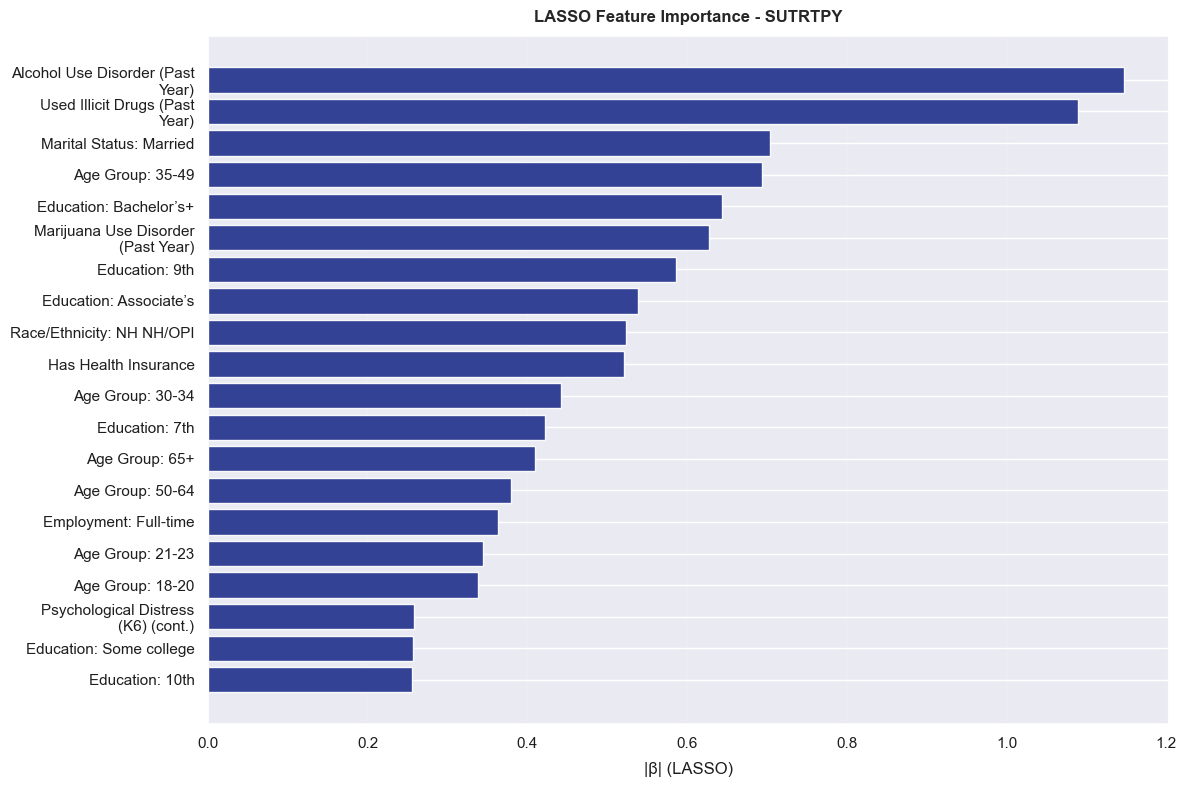

Saved: ../output_reports\SUTRTPY/lasso_output\lasso_SUTRTPY_feature_importance_pretty.png


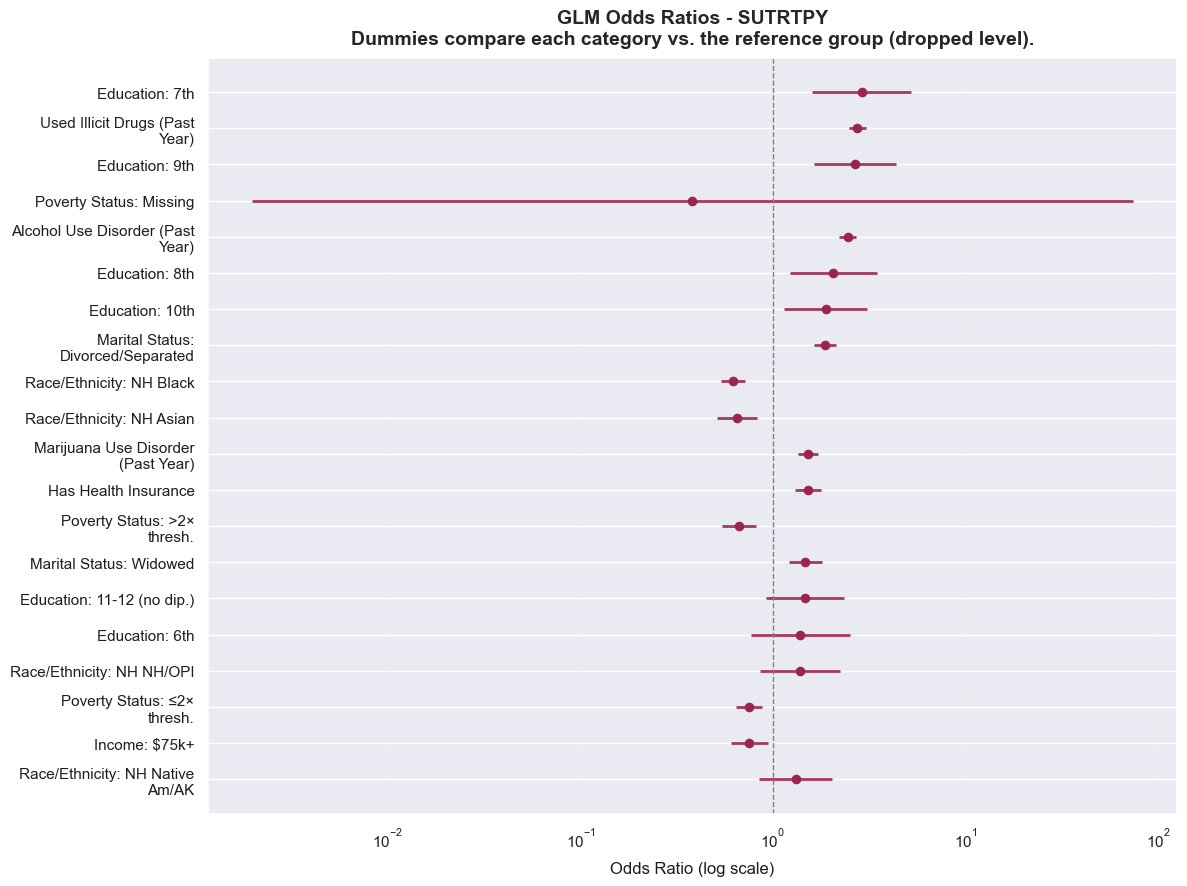

Saved: ../output_reports\SUTRTPY/glm_output\glm_SUTRTPY_forest_pretty.png


In [14]:
plot_lasso_from_export_pretty("SUTRTPY", top_n=20)
plot_glm_forest_from_export_pretty("SUTRTPY", top_n=20,
    ref_note="Dummies compare each category vs. the reference group (dropped level).")

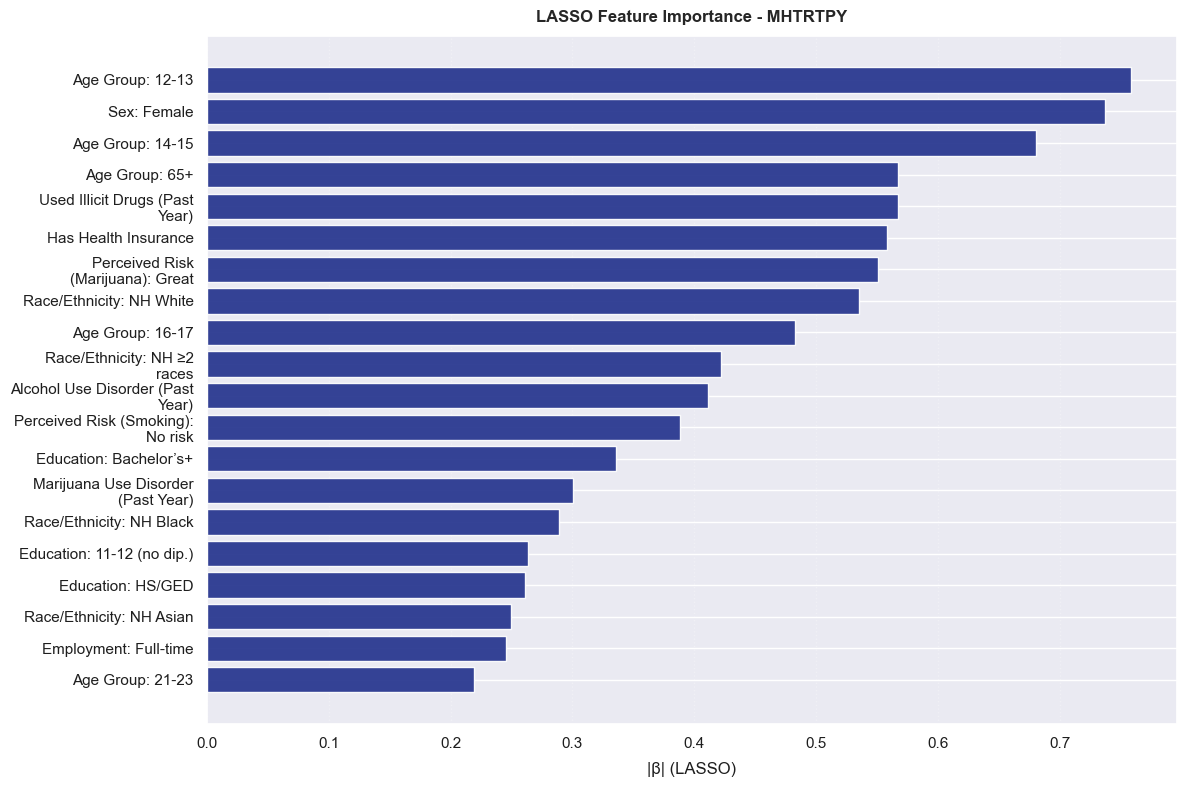

Saved: ../output_reports\MHTRTPY/lasso_output\lasso_MHTRTPY_feature_importance_pretty.png


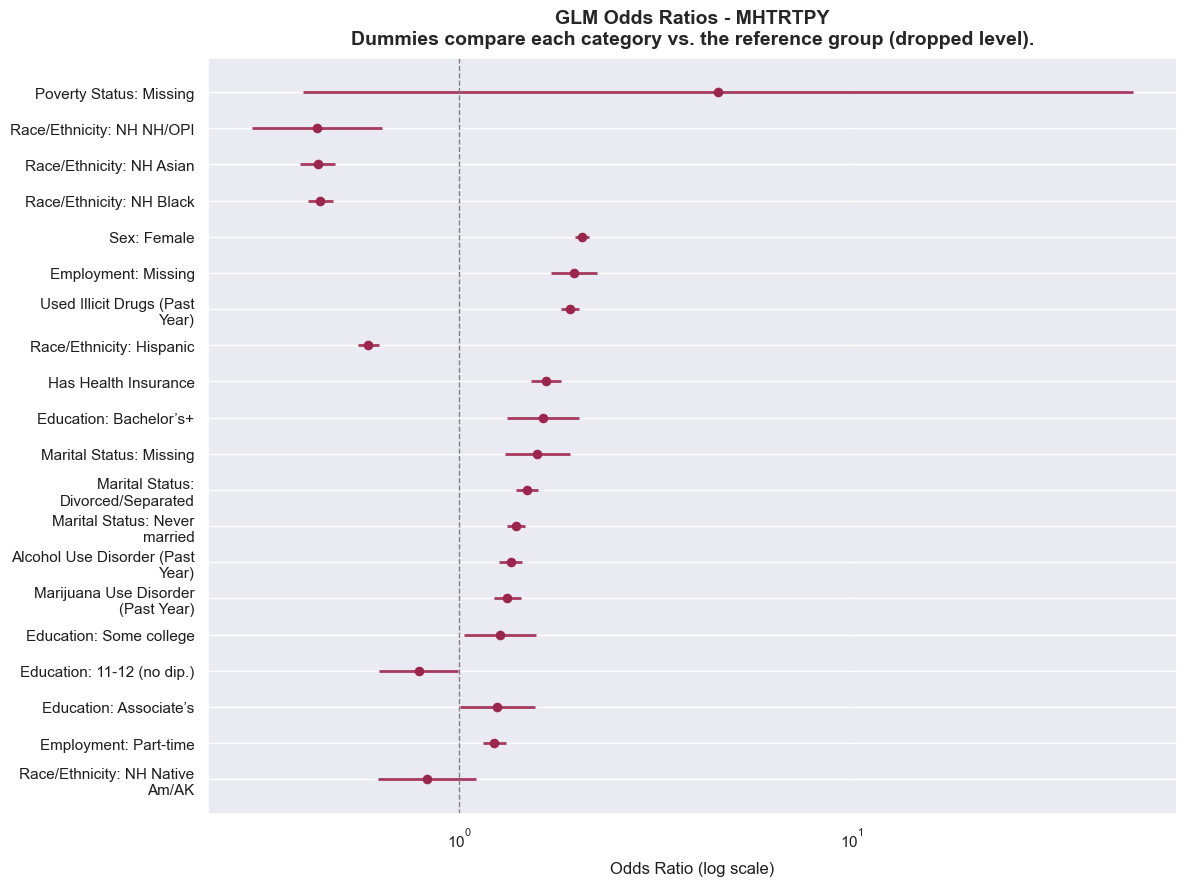

Saved: ../output_reports\MHTRTPY/glm_output\glm_MHTRTPY_forest_pretty.png


In [15]:
plot_lasso_from_export_pretty("MHTRTPY", top_n=20)
plot_glm_forest_from_export_pretty("MHTRTPY", top_n=20,
    ref_note="Dummies compare each category vs. the reference group (dropped level).")

#### 4.2. Logistic Regression Model for SUTRTPY using variables captured by LASSO

In [87]:
target = "SUTRTPY"
weight = "ANALWT2_C"

# Top 10 LASSO predictors by absolute coefficient
top_lasso_features = [
    "IRPYUD5ALC", "ILLYR", "IRMARIT", "IREDUHIGHST2",
    "IRPYUD5MRJ", "NEWRACE2", "IRINSUR4", "IRWRKSTAT18", "KSSLR6YR"
]

# Add core demographics for interpretability
core_demo = ["IRSEX", "POVERTY3", "INCOME"]

selected_features = list(dict.fromkeys(top_lasso_features + core_demo))  # ensure uniqueness

print("Variables included in final model:")
for v in selected_features:
    print("-", v)

# Prepare data
work = df.loc[df[target].notna() & df[weight].notna(), [target, weight] + selected_features].copy()
work[target] = pd.to_numeric(work[target], errors="coerce")
work[weight] = pd.to_numeric(work[weight], errors="coerce")

# Identify numeric predictors (continuous)
numeric_cols = ["KSSLR6YR"]
categorical_cols = [c for c in selected_features if c not in numeric_cols]

# Median impute numeric
for c in numeric_cols:
    med = pd.to_numeric(work[c], errors="coerce").median()
    work[c] = pd.to_numeric(work[c], errors="coerce").fillna(med)

# Dummy encoding and cleanup
X_parts = []
for c in categorical_cols:
    # replace NaN with a literal "Missing" category
    work[c] = work[c].astype("category").cat.add_categories("Missing").fillna("Missing")
    dummies = pd.get_dummies(work[c], prefix=c, drop_first=True)
    X_parts.append(dummies)

X_cat = pd.concat(X_parts, axis=1)
X_num = work[numeric_cols]
X = pd.concat([X_cat, X_num], axis=1)

# Coerce to numeric and clean
X = X.apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan)
y = pd.to_numeric(work[target], errors="coerce")
w = pd.to_numeric(work[weight], errors="coerce")

keep = X.notna().all(axis=1) & y.notna() & w.notna()
X = X.loc[keep]
y = y.loc[keep]
w = w.loc[keep]

# Drop constant or duplicate columns
X = X.loc[:, X.nunique(dropna=False) > 1]
X = X.loc[:, ~X.T.duplicated()]

# Add intercept
X = sm.add_constant(X).astype(float)
y = y.astype(float)
w = w.astype(float)

print(f"\nModel fitting on {len(X):,} observations, {X.shape[1]} predictors.")

# weighted logistic regression (robust SEs)
N = len(w)
w_freq = w * (N / w.sum())   # scale such that sum(w_freq) == N

print("sum(freq_weights) =", w_freq.sum())  # sanity: should equal N
print("rank(X) vs cols:", np.linalg.matrix_rank(X.values), X.shape[1])

model = sm.GLM(y, X, family=sm.families.Binomial(), freq_weights=w_freq).fit(cov_type="HC1")
print(model.summary())

# Compute Odds Ratios with 95% CI
ci = model.conf_int()
ci.columns = ["2.5%", "97.5%"]
or_table = pd.DataFrame({
    "OR": np.exp(model.params),
    "2.5%": np.exp(ci["2.5%"]),
    "97.5%": np.exp(ci["97.5%"]),
    "p-value": model.pvalues
}).sort_values("OR", ascending=False)

print("\nTop predictors by OR:")
print(or_table.head(15))

print("\nLowest predictors by OR:")
print(or_table.tail(15))

# Save text summary
with open(os.path.join(outdir + "/SUTRTPY/glm_output/", f"glm_{target}_summary.txt"), "w") as f:
    f.write(model.summary().as_text())

# Save full OR table
or_table.to_csv(os.path.join(outdir + "/SUTRTPY/glm_output/", f"glm_{target}_or_table.csv"))

# Save compact (manuscript-ready) table
nice = or_table.copy()
nice["OR (95% CI)"] = nice.apply(lambda r: f'{r["OR"]:.2f} ({r["2.5%"]:.2f}, {r["97.5%"]:.2f})', axis=1)
nice = nice[["OR (95% CI)", "p-value"]]
nice.to_csv(os.path.join(outdir + "/SUTRTPY/glm_output/", f"glm_{target}_or_table_compact.csv"))

Variables included in final model:
- IRPYUD5ALC
- ILLYR
- IRMARIT
- IREDUHIGHST2
- IRPYUD5MRJ
- NEWRACE2
- IRINSUR4
- IRWRKSTAT18
- KSSLR6YR
- IRSEX
- POVERTY3
- INCOME

Model fitting on 56,705 observations, 37 predictors.
sum(freq_weights) = 56705.0
rank(X) vs cols: 37 37
                 Generalized Linear Model Regression Results                  
Dep. Variable:                SUTRTPY   No. Observations:                56705
Model:                            GLM   Df Residuals:                    56668
Model Family:                Binomial   Df Model:                           36
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9101.8
Date:                Sun, 19 Oct 2025   Deviance:                       18204.
Time:                        23:52:24   Pearson chi2:                 5.77e+04
No. Iterations:                     7   Pseudo R-squ. (CS):            0.04423
Covariance Type

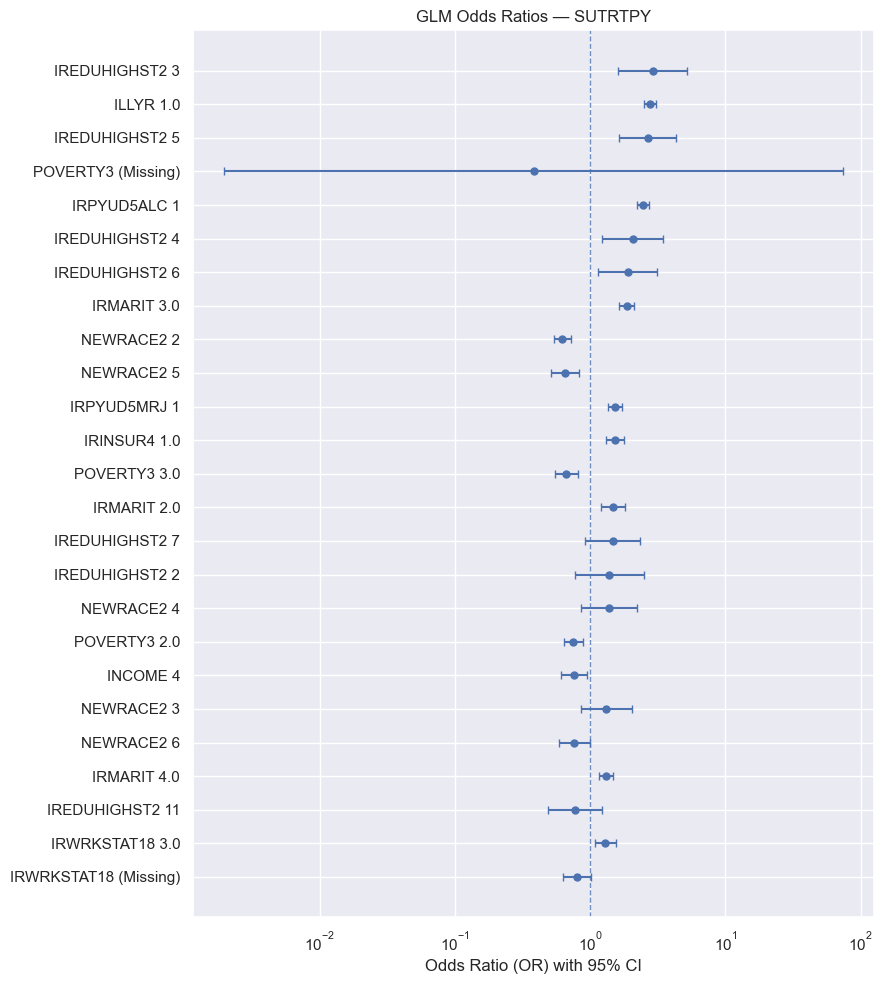

In [6]:
# -------------------------------------
# 1) Choose which model to visualize
#    (change to glm_MHTRTPY_or_table.csv or glm_TELEAPTYR_or_table.csv)
# -------------------------------------
or_csv = "../output_reports/SUTRTPY/glm_output/glm_SUTRTPY_or_table.csv"

# -------------------------------------
# 2) Load & tidy
# -------------------------------------
or_df = pd.read_csv(or_csv, index_col=0)  # index is the term name
# Drop intercept if present
or_df = or_df.loc[[i for i in or_df.index if i.lower() not in ("const","intercept")]]

# Add log scale for sorting by “distance” from null (OR=1)
or_df["logOR"] = np.log(or_df["OR"])
or_df["log2.5%"] = np.log(or_df["2.5%"])
or_df["log97.5%"] = np.log(or_df["97.5%"])
or_df["abs_logOR"] = or_df["logOR"].abs()

# Optional: make labels a bit cleaner
labels = (or_df.index
          .str.replace("^const$", "Intercept", regex=True)
          .str.replace("_Missing", " (Missing)", regex=False)
          .str.replace("_", " ", regex=False))

# -------------------------------------
# 3) Pick top N coefficients by |logOR|
# -------------------------------------
top_n = 25
plot_df = or_df.sort_values("abs_logOR", ascending=False).head(top_n).copy()

# Convert labels index → Series so we can align correctly
labels = pd.Series(
    (or_df.index
     .str.replace("^const$", "Intercept", regex=True)
     .str.replace("_Missing", " (Missing)", regex=False)
     .str.replace("_", " ", regex=False)),
    index=or_df.index
)

# Use .reindex() instead of .loc for safety
plot_labels = labels.reindex(plot_df.index)

# Compute error bars (on log scale) and then exponentiate back to OR scale
x = plot_df["OR"].values
xerr_low  = x - plot_df["2.5%"].values
xerr_high = plot_df["97.5%"].values - x

# -------------------------------------
# 4) Plot (forest plot style)
# -------------------------------------
plt.figure(figsize=(9, 10))

y_pos = np.arange(len(plot_df))[::-1]  # top to bottom
plt.errorbar(
    x, y_pos,
    xerr=[xerr_low, xerr_high],
    fmt='o', capsize=3, elinewidth=1.5, markersize=5
)

# Reference line at OR=1
plt.axvline(1.0, linestyle='--', linewidth=1, alpha=0.8)

plt.yticks(y_pos, plot_labels)
plt.xlabel("Odds Ratio (OR) with 95% CI")
plt.title(f"GLM Odds Ratios — {os.path.basename(or_csv).replace('glm_','').replace('_or_table.csv','')}")
plt.xscale("log")  # log scale makes symmetric around 1
plt.tight_layout()

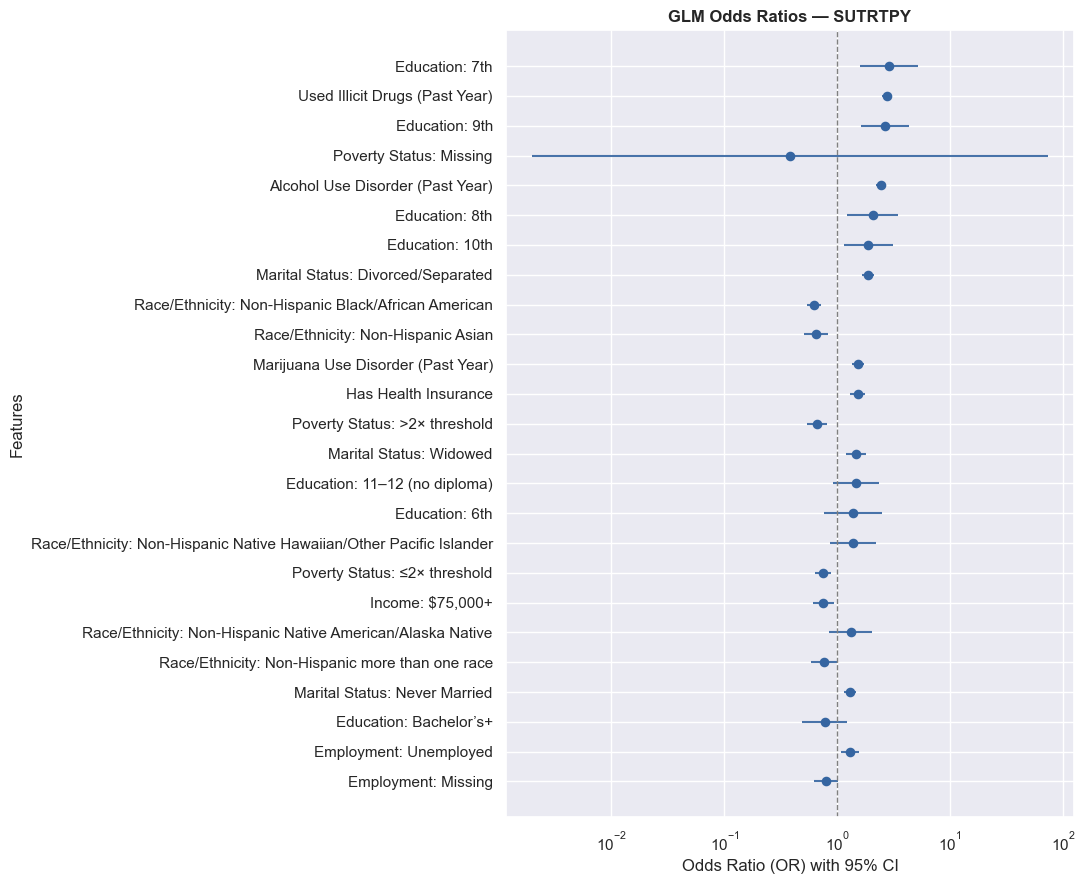

Saved: ../output_reports\SUTRTPY/glm_output\glm_SUTRTPY_forest.png


In [6]:
# GLM
plot_glm_forest_from_export(target="SUTRTPY", outdir="../output_reports", top_n=25)

#### 4.3. Random Forest Model for SUTRTPY


Random Forest results for SUTRTPY:
AUC (weighted): 0.780
Accuracy (weighted, thr=0.5): 0.957


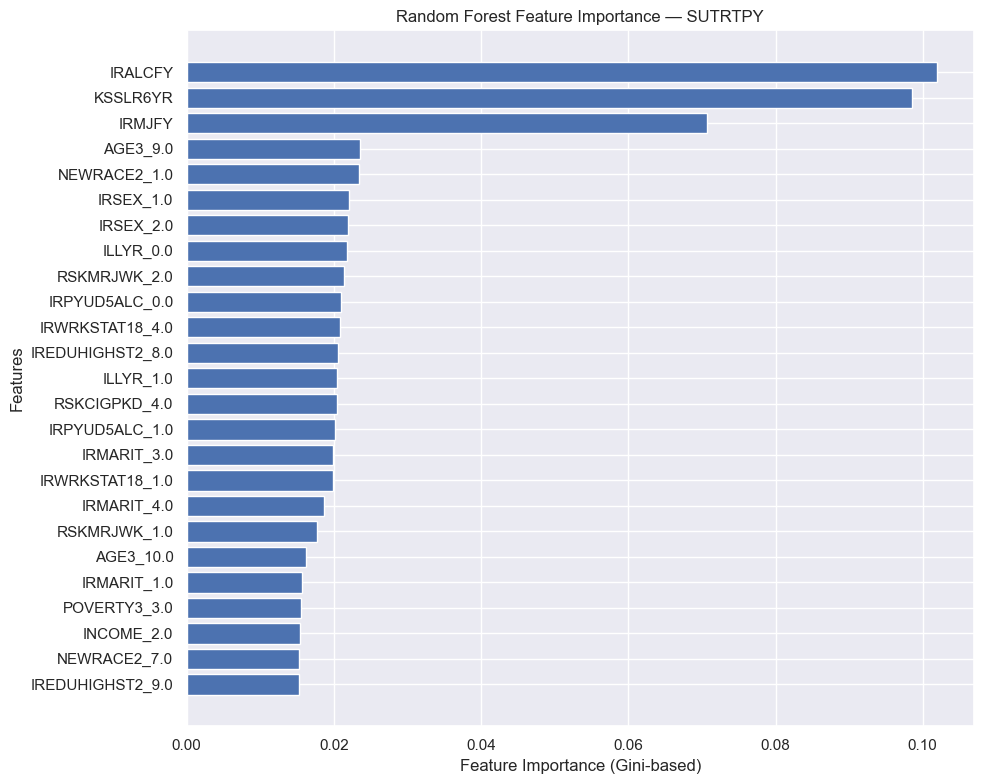

In [88]:
target = "SUTRTPY"   
weight = "ANALWT2_C"

numeric_cols = ["IRALCFY", "IRMJFY", "KSSLR6YR"]

categorical_cols = [
    "AGE3","IRSEX","NEWRACE2",
    "IRMARIT","IREDUHIGHST2","IRWRKSTAT18",
    "IRINSUR4","INCOME","POVERTY3",
    "IRPYUD5ALC","IRPYUD5MRJ","ILLYR",
    "RSKCIGPKD","RSKMRJWK"
]

work = df.loc[df[target].notna() & df[weight].notna()].copy()
work["w_norm"] = work[weight] / work[weight].mean()

X = work[categorical_cols + numeric_cols]
y = work[target].astype(int).to_numpy().ravel()
w = work["w_norm"].astype(float).to_numpy().ravel()

# Train-test split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w, test_size=0.25, random_state=123, stratify=y
)

# Preprocessing
pre = ColumnTransformer(
    transformers=[
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), categorical_cols),
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_cols),
    ],
    remainder="drop"
)

# Random Forest
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=123,
    n_jobs=-1,
    class_weight=None  
)

pipe_rf = Pipeline([
    ("pre", pre),
    ("clf", rf)
])

pipe_rf.fit(X_train, y_train, clf__sample_weight=w_train)

# Evaluate
y_prob = pipe_rf.predict_proba(X_test)[:, 1]
y_hat  = (y_prob >= 0.5).astype(int)

auc = roc_auc_score(y_test, y_prob, sample_weight=w_test)
acc = accuracy_score(y_test, y_hat, sample_weight=w_test)

print(f"\nRandom Forest results for {target}:")
print(f"AUC (weighted): {auc:.3f}")
print(f"Accuracy (weighted, thr=0.5): {acc:.3f}")

metrics = {
    "target": target,
    "AUC_weighted": float(auc),
    "Accuracy_weighted_thr0.5": float(acc),
    "N_train": len(y_train),
    "N_test": len(y_test)
}

# Save metrics JSON
with open(os.path.join(outdir + "/SUTRTPY/rf_output/", f"rf_{target}_metrics.json"), "w") as f:
    json.dump(metrics, f, indent=2)

# Feature Importance
# Get feature names after preprocessing
cat_names = pipe_rf.named_steps["pre"].named_transformers_["cat"].named_steps["ohe"].get_feature_names_out(categorical_cols)
feature_names = list(cat_names) + numeric_cols

importances = pipe_rf.named_steps["clf"].feature_importances_
imp_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
imp_df = imp_df.sort_values("Importance", ascending=False)

imp_df.to_csv(os.path.join(outdir + "/SUTRTPY/rf_output/", f"rf_{target}_feature_importance.csv"), index=False)


# Plot & Export
top_n = 25
plt.figure(figsize=(10, 8))
plt.barh(imp_df["Feature"].head(top_n), imp_df["Importance"].head(top_n))
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance (Gini-based)")
plt.ylabel("Features")
plt.title(f"Random Forest Feature Importance — {target}")
plt.tight_layout()

plt.savefig(os.path.join(outdir_graph, f"rf_{target}_feature_importance.png"), dpi=200)
plt.show()

#### 4.4. LASSO Logistic Regression Model for MHTRTPY

In [89]:
target = "MHTRTPY"
weight = "ANALWT2_C"

# Numeric (continuous count/score) features
numeric_cols = ["IRALCFY", "IRMJFY", "KSSLR6YR"]

# Treat coded fields as categorical (one-hot)
categorical_cols = [
    "AGE3","IRSEX","NEWRACE2",
    "IRMARIT","IREDUHIGHST2","IRWRKSTAT18",
    "IRINSUR4","INCOME","POVERTY3",
    "IRPYUD5ALC","IRPYUD5MRJ","ILLYR",
    "RSKCIGPKD","RSKMRJWK"
]

# Keep rows with target and weight
work = df.loc[df[target].notna() & df[weight].notna()].copy()
work["w_norm"] = work[weight] / work[weight].mean()

X = work[categorical_cols + numeric_cols]
y = work[target].astype(int).to_numpy().ravel()
w = work["w_norm"].astype(float).to_numpy().ravel()

# Train / test split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w, test_size=0.25, random_state=123, stratify=y
)

# Preprocess (impute+encode categoricals, impute+scale numerics)
pre = ColumnTransformer(
    transformers=[
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True, drop="if_binary"))
        ]), categorical_cols),
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler(with_mean=False))  # keep sparse compatibility
        ]), numeric_cols),
    ],
    remainder="drop",
    sparse_threshold=1.0
)

# LASSO logistic (CV on C), weighted fit
C_grid = np.logspace(-3, 1, 12)

lasso_cv = LogisticRegressionCV(
    Cs=C_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=123),
    penalty="l1",
    solver="saga",
    scoring="roc_auc",
    max_iter=10000,
    n_jobs=-1,
    refit=True
)

pipe = Pipeline([
    ("pre", pre),
    ("clf", lasso_cv)
])

pipe.fit(X_train, y_train, clf__sample_weight=w_train)

# Evaluate
y_prob = pipe.predict_proba(X_test)[:, 1]
y_hat  = (y_prob >= 0.5).astype(int)
auc    = roc_auc_score(y_test, y_prob, sample_weight=w_test)
acc    = accuracy_score(y_test, y_hat, sample_weight=w_test)

print(f"AUC (weighted): {auc:.3f}")
print(f"Accuracy (weighted, thr=0.5): {acc:.3f}")

# Coefficients + selected features (non-zero)
ohe = pipe.named_steps["pre"].named_transformers_["cat"].named_steps["ohe"]
cat_names = list(ohe.get_feature_names_out(categorical_cols))
feature_names = cat_names + numeric_cols

coef = pipe.named_steps["clf"].coef_.ravel()
selected = [(name, float(wt)) for name, wt in zip(feature_names, coef) if wt != 0]

print(f"Selected features (non-zero): {len(selected)}")
for name, wt in sorted(selected, key=lambda x: abs(x[1]), reverse=True)[:40]:
    print(f"{wt:+.4f}  {name}")

# Metrics
y_prob = pipe.predict_proba(X_test)[:, 1]
y_hat  = (y_prob >= 0.5).astype(int)
auc    = roc_auc_score(y_test, y_prob, sample_weight=w_test)
acc    = accuracy_score(y_test, y_hat, sample_weight=w_test)

with open(os.path.join(outdir + "/MHTRTPY/lasso_output/", f"lasso_{target}_metrics.json"), "w") as f:
    json.dump({"AUC_weighted": float(auc),
               "Accuracy_weighted_thr0.5": float(acc)}, f, indent=2)

# Coefficients 
ohe = pipe.named_steps["pre"].named_transformers_["cat"].named_steps["ohe"]
cat_names = list(ohe.get_feature_names_out(categorical_cols))
feature_names = cat_names + numeric_cols

coef = pipe.named_steps["clf"].coef_.ravel()
coef_df = pd.DataFrame({"feature": feature_names, "coef": coef})
coef_df = coef_df.loc[coef_df["coef"] != 0].copy()
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df.sort_values("abs_coef", ascending=False, inplace=True)

coef_df[["feature","coef"]].to_csv(
    os.path.join(outdir + "/MHTRTPY/lasso_output/", f"lasso_{target}_coefficients.csv"), index=False
)


AUC (weighted): 0.700
Accuracy (weighted, thr=0.5): 0.776
Selected features (non-zero): 52
+0.7580  AGE3_1.0
+0.7370  IRSEX_2.0
+0.6806  AGE3_2.0
-0.5668  AGE3_11.0
+0.5668  ILLYR_1.0
+0.5584  IRINSUR4_1.0
-0.5502  RSKMRJWK_4.0
+0.5347  NEWRACE2_1.0
+0.4826  AGE3_3.0
+0.4219  NEWRACE2_6.0
+0.4109  IRPYUD5ALC_1.0
-0.3884  RSKCIGPKD_1.0
+0.3356  IREDUHIGHST2_11.0
+0.3004  IRPYUD5MRJ_1.0
-0.2892  NEWRACE2_2.0
-0.2635  IREDUHIGHST2_7.0
-0.2607  IREDUHIGHST2_8.0
-0.2496  NEWRACE2_5.0
-0.2451  IRWRKSTAT18_1.0
-0.2192  AGE3_5.0
+0.2009  KSSLR6YR
-0.1992  AGE3_10.0
-0.1767  IRMARIT_1.0
-0.1658  IRMARIT_2.0
-0.1601  POVERTY3_1.0
-0.1535  RSKMRJWK_3.0
-0.1461  RSKCIGPKD_2.0
+0.1425  IRMARIT_3.0
-0.1317  INCOME_4.0
-0.1212  IRALCFY
+0.1176  IREDUHIGHST2_9.0
-0.1140  AGE3_4.0
+0.0889  INCOME_1.0
-0.0835  IREDUHIGHST2_4.0
-0.0823  IRWRKSTAT18_3.0
+0.0694  AGE3_8.0
-0.0501  IREDUHIGHST2_3.0
+0.0497  RSKMRJWK_2.0
+0.0473  IREDUHIGHST2_10.0
-0.0444  INCOME_2.0


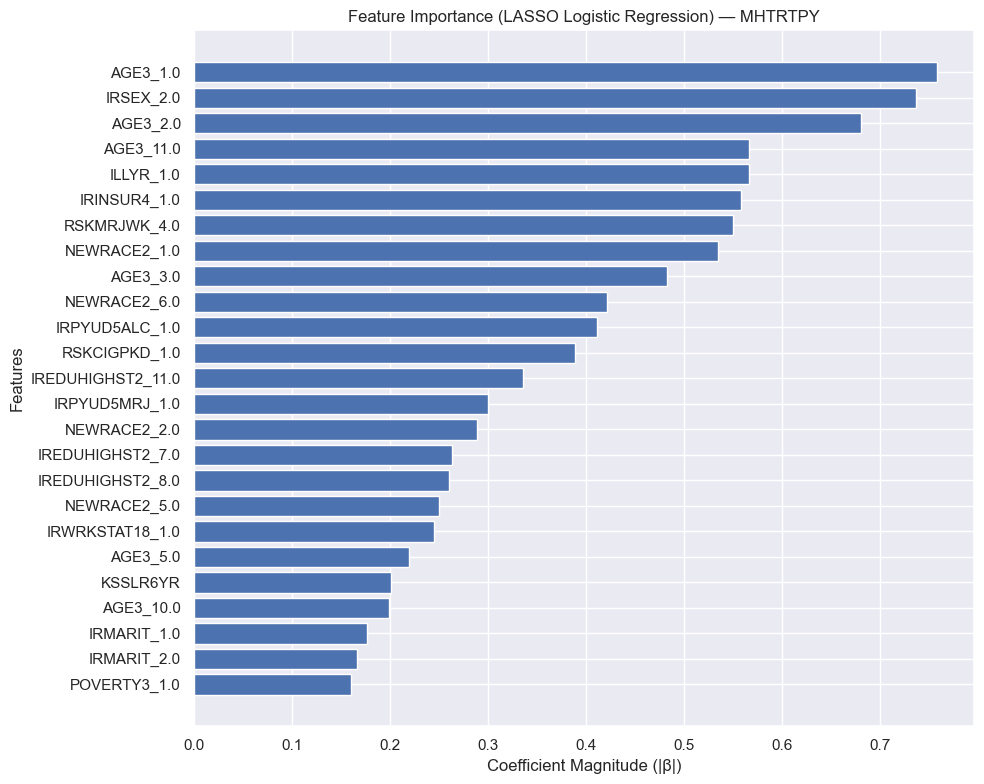

In [90]:
target = "MHTRTPY" 
coef_path = os.path.join(outdir + "/MHTRTPY/lasso_output/", f"lasso_{target}_coefficients.csv")
top_n = 25           # number of features to display

coef_df = pd.read_csv(coef_path)

# Clean and prepare
coef_df = coef_df.rename(columns={"feature": "Feature", "coef": "Coefficient"})
coef_df["AbsCoef"] = coef_df["Coefficient"].abs()

# Sort by absolute magnitude (descending)
coef_df = coef_df.sort_values(by="AbsCoef", ascending=False, ignore_index=True)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(coef_df["Feature"].head(top_n), coef_df["AbsCoef"].head(top_n)) 
plt.xlabel("Coefficient Magnitude (|β|)")
plt.ylabel("Features")
plt.title(f"Feature Importance (LASSO Logistic Regression) — {target}")
plt.gca().invert_yaxis()  
plt.tight_layout()

save_path = os.path.join(outdir_graph, f"lasso_{target}_feature_importance_from_export.png")
plt.savefig(save_path, dpi=200)
plt.show()

#### 4.5. Logistic Regression Model for MHTRTPY using variables captured by LASSO

In [91]:
target = "MHTRTPY"
weight = "ANALWT2_C"

# Top 10 LASSO predictors
top_lasso_features = [
    "IRSEX", "IRINSUR4", "ILLYR", "IRPYUD5ALC", "IRPYUD5MRJ",
    "KSSLR6YR", "NEWRACE2", "IRMARIT", "IREDUHIGHST2", "IRWRKSTAT18"
]

# Add socioeconomic context vars
core_demo = ["INCOME", "POVERTY3"]

selected_features = list(dict.fromkeys(top_lasso_features + core_demo))

print("Variables included in MHTRTPY model:")
for v in selected_features:
    print("-", v)

# Prepare data
work = df.loc[df[target].notna() & df[weight].notna(), [target, weight] + selected_features].copy()
work[target] = pd.to_numeric(work[target], errors="coerce")
work[weight] = pd.to_numeric(work[weight], errors="coerce")

# Numeric vs categorical
numeric_cols = ["KSSLR6YR"]
categorical_cols = [c for c in selected_features if c not in numeric_cols]

# Median impute numeric
for c in numeric_cols:
    med = pd.to_numeric(work[c], errors="coerce").median()
    work[c] = pd.to_numeric(work[c], errors="coerce").fillna(med)

# Dummy encoding (explicit Missing category)
X_parts = []
for c in categorical_cols:
    work[c] = work[c].astype("category").cat.add_categories("Missing").fillna("Missing")
    dummies = pd.get_dummies(work[c], prefix=c, drop_first=True)
    X_parts.append(dummies)

X_cat = pd.concat(X_parts, axis=1)
X_num = work[numeric_cols]
X = pd.concat([X_cat, X_num], axis=1)

# Clean dtypes
X = X.apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan)
y = pd.to_numeric(work[target], errors="coerce")
w = pd.to_numeric(work[weight], errors="coerce")

keep = X.notna().all(axis=1) & y.notna() & w.notna()
X = X.loc[keep]
y = y.loc[keep]
w = w.loc[keep]

# Drop constants/duplicates
X = X.loc[:, X.nunique(dropna=False) > 1]
X = X.loc[:, ~X.T.duplicated()]

# Add constant
X = sm.add_constant(X).astype(float)
y = y.astype(float)
w = w.astype(float)

# Fit weighted logistic regression (robust SEs)
N = len(w)
w_freq = w * (N / w.sum())   # scaled so sum(weights) == N

print(f"\nModel fitting on {N:,} observations, {X.shape[1]} predictors.")
print("sum(freq_weights) =", w_freq.sum())
print("rank(X) vs cols:", np.linalg.matrix_rank(X.values), X.shape[1])

model = sm.GLM(y, X, family=sm.families.Binomial(), freq_weights=w_freq).fit(cov_type="HC1")
print(model.summary())

# Compute Odds Ratios with 95% CI
ci = model.conf_int()
ci.columns = ["2.5%", "97.5%"]
or_table = pd.DataFrame({
    "OR": np.exp(model.params),
    "2.5%": np.exp(ci["2.5%"]),
    "97.5%": np.exp(ci["97.5%"]),
    "p-value": model.pvalues
}).sort_values("OR", ascending=False)

print("\nTop predictors by OR:")
print(or_table.head(15))
print("\nLowest predictors by OR:")
print(or_table.tail(15))

# Save text summary 
with open(os.path.join(outdir + "/MHTRTPY/glm_output/", f"glm_{target}_summary.txt"), "w") as f:
    f.write(model.summary().as_text())

# Save full OR table
or_table.to_csv(os.path.join(outdir + "/MHTRTPY/glm_output/", f"glm_{target}_or_table.csv"))

# Save compact (manuscript-ready) table
nice = or_table.copy()
nice["OR (95% CI)"] = nice.apply(lambda r: f'{r["OR"]:.2f} ({r["2.5%"]:.2f}, {r["97.5%"]:.2f})', axis=1)
nice = nice[["OR (95% CI)", "p-value"]]
nice.to_csv(os.path.join(outdir + "/MHTRTPY/glm_output/", f"glm_{target}_or_table_compact.csv"))

Variables included in MHTRTPY model:
- IRSEX
- IRINSUR4
- ILLYR
- IRPYUD5ALC
- IRPYUD5MRJ
- KSSLR6YR
- NEWRACE2
- IRMARIT
- IREDUHIGHST2
- IRWRKSTAT18
- INCOME
- POVERTY3

Model fitting on 56,705 observations, 37 predictors.
sum(freq_weights) = 56705.0
rank(X) vs cols: 37 37
                 Generalized Linear Model Regression Results                  
Dep. Variable:                MHTRTPY   No. Observations:                56705
Model:                            GLM   Df Residuals:                    56668
Model Family:                Binomial   Df Model:                           36
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28477.
Date:                Sun, 19 Oct 2025   Deviance:                       56955.
Time:                        23:52:54   Pearson chi2:                 5.77e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.09143
Covariance Ty

#### 4.6. Random Forest Model for MHTRTPY   


Random Forest results for MHTRTPY:
AUC (weighted): 0.732
Accuracy (weighted, thr=0.5): 0.789


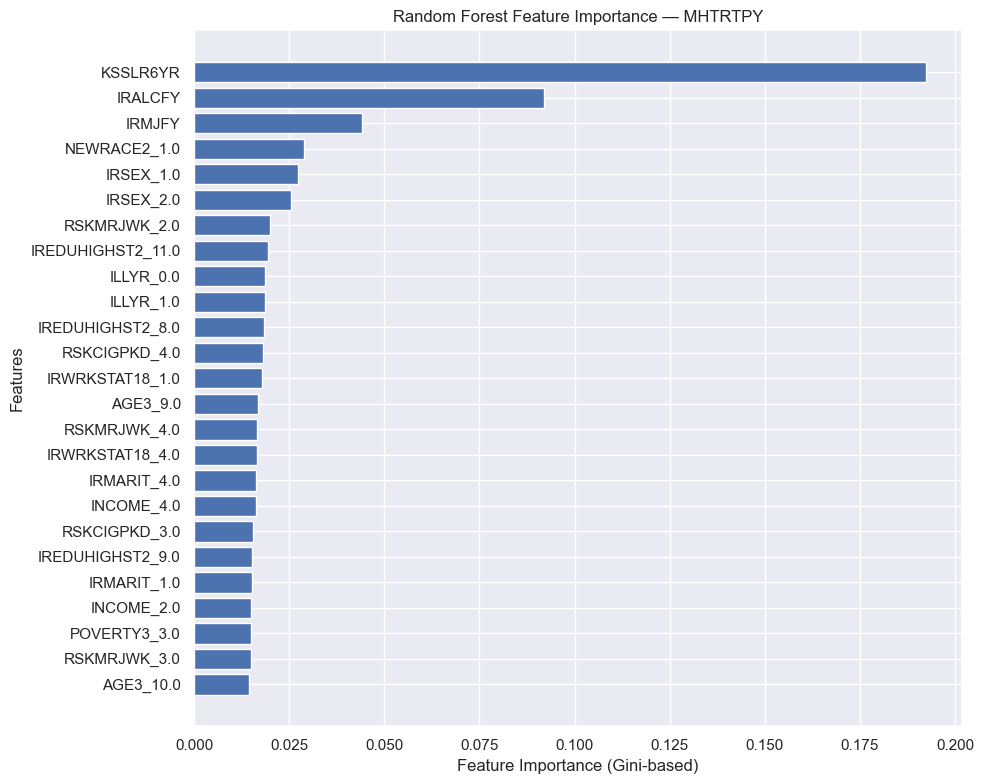

In [92]:
target = "MHTRTPY"   
weight = "ANALWT2_C"

numeric_cols = ["IRALCFY", "IRMJFY", "KSSLR6YR"]

categorical_cols = [
    "AGE3","IRSEX","NEWRACE2",
    "IRMARIT","IREDUHIGHST2","IRWRKSTAT18",
    "IRINSUR4","INCOME","POVERTY3",
    "IRPYUD5ALC","IRPYUD5MRJ","ILLYR",
    "RSKCIGPKD","RSKMRJWK"
]

work = df.loc[df[target].notna() & df[weight].notna()].copy()
work["w_norm"] = work[weight] / work[weight].mean()

X = work[categorical_cols + numeric_cols]
y = work[target].astype(int).to_numpy().ravel()
w = work["w_norm"].astype(float).to_numpy().ravel()

# Train-test split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w, test_size=0.25, random_state=123, stratify=y
)

# Preprocessing
pre = ColumnTransformer(
    transformers=[
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), categorical_cols),
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_cols),
    ],
    remainder="drop"
)

# Random Forest
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=123,
    n_jobs=-1,
    class_weight=None  
)

pipe_rf = Pipeline([
    ("pre", pre),
    ("clf", rf)
])

pipe_rf.fit(X_train, y_train, clf__sample_weight=w_train)

# Evaluate
y_prob = pipe_rf.predict_proba(X_test)[:, 1]
y_hat  = (y_prob >= 0.5).astype(int)

auc = roc_auc_score(y_test, y_prob, sample_weight=w_test)
acc = accuracy_score(y_test, y_hat, sample_weight=w_test)

print(f"\nRandom Forest results for {target}:")
print(f"AUC (weighted): {auc:.3f}")
print(f"Accuracy (weighted, thr=0.5): {acc:.3f}")

metrics = {
    "target": target,
    "AUC_weighted": float(auc),
    "Accuracy_weighted_thr0.5": float(acc),
    "N_train": len(y_train),
    "N_test": len(y_test)
}

# Save metrics JSON
with open(os.path.join(outdir + "/MHTRTPY/rf_output/", f"rf_{target}_metrics.json"), "w") as f:
    json.dump(metrics, f, indent=2)

# Feature Importance
# Get feature names after preprocessing
cat_names = pipe_rf.named_steps["pre"].named_transformers_["cat"].named_steps["ohe"].get_feature_names_out(categorical_cols)
feature_names = list(cat_names) + numeric_cols

importances = pipe_rf.named_steps["clf"].feature_importances_
imp_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
imp_df = imp_df.sort_values("Importance", ascending=False)

imp_df.to_csv(os.path.join(outdir + "/MHTRTPY/rf_output/", f"rf_{target}_feature_importance.csv"), index=False)


# Plot & Export
top_n = 25
plt.figure(figsize=(10, 8))
plt.barh(imp_df["Feature"].head(top_n), imp_df["Importance"].head(top_n))
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance (Gini-based)")
plt.ylabel("Features")
plt.title(f"Random Forest Feature Importance — {target}")
plt.tight_layout()

plt.savefig(os.path.join(outdir_graph, f"rf_{target}_feature_importance.png"), dpi=200)
plt.show()

#### 4.7. LASSO Logistic Regression Model for TELEAPTYR

In [93]:
target = "TELEAPTYR"
weight = "ANALWT2_C"

# Numeric (continuous count/score) features
numeric_cols = ["IRALCFY", "IRMJFY", "KSSLR6YR"]

# Treat coded fields as categorical (one-hot)
categorical_cols = [
    "AGE3","IRSEX","NEWRACE2",
    "IRMARIT","IREDUHIGHST2","IRWRKSTAT18",
    "IRINSUR4","INCOME","POVERTY3",
    "IRPYUD5ALC","IRPYUD5MRJ","ILLYR",
    "RSKCIGPKD","RSKMRJWK"
]

# Keep rows with target and weight
work = df.loc[df[target].notna() & df[weight].notna()].copy()
work["w_norm"] = work[weight] / work[weight].mean()

X = work[categorical_cols + numeric_cols]
y = work[target].astype(int).to_numpy().ravel()
w = work["w_norm"].astype(float).to_numpy().ravel()

# Train / test split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w, test_size=0.25, random_state=123, stratify=y
)

# Preprocess (impute+encode categoricals, impute+scale numerics)
pre = ColumnTransformer(
    transformers=[
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True, drop="if_binary"))
        ]), categorical_cols),
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler(with_mean=False))  # keep sparse compatibility
        ]), numeric_cols),
    ],
    remainder="drop",
    sparse_threshold=1.0
)

# LASSO logistic (CV on C), weighted fit
C_grid = np.logspace(-3, 1, 12)

lasso_cv = LogisticRegressionCV(
    Cs=C_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=123),
    penalty="l1",
    solver="saga",
    scoring="roc_auc",
    max_iter=10000,
    n_jobs=-1,
    refit=True
)

pipe = Pipeline([
    ("pre", pre),
    ("clf", lasso_cv)
])

pipe.fit(X_train, y_train, clf__sample_weight=w_train)

# Evaluate
y_prob = pipe.predict_proba(X_test)[:, 1]
y_hat  = (y_prob >= 0.5).astype(int)
auc    = roc_auc_score(y_test, y_prob, sample_weight=w_test)
acc    = accuracy_score(y_test, y_hat, sample_weight=w_test)

print(f"AUC (weighted): {auc:.3f}")
print(f"Accuracy (weighted, thr=0.5): {acc:.3f}")

# Coefficients + selected features (non-zero)
ohe = pipe.named_steps["pre"].named_transformers_["cat"].named_steps["ohe"]
cat_names = list(ohe.get_feature_names_out(categorical_cols))
feature_names = cat_names + numeric_cols

coef = pipe.named_steps["clf"].coef_.ravel()
selected = [(name, float(wt)) for name, wt in zip(feature_names, coef) if wt != 0]

print(f"Selected features (non-zero): {len(selected)}")
for name, wt in sorted(selected, key=lambda x: abs(x[1]), reverse=True)[:40]:
    print(f"{wt:+.4f}  {name}")

# Metrics
y_prob = pipe.predict_proba(X_test)[:, 1]
y_hat  = (y_prob >= 0.5).astype(int)
auc    = roc_auc_score(y_test, y_prob, sample_weight=w_test)
acc    = accuracy_score(y_test, y_hat, sample_weight=w_test)

with open(os.path.join(outdir + "/TELEAPTYR/lasso_output/", f"lasso_{target}_metrics.json"), "w") as f:
    json.dump({"AUC_weighted": float(auc),
               "Accuracy_weighted_thr0.5": float(acc)}, f, indent=2)

# Coefficients
ohe = pipe.named_steps["pre"].named_transformers_["cat"].named_steps["ohe"]
cat_names = list(ohe.get_feature_names_out(categorical_cols))
feature_names = cat_names + numeric_cols

coef = pipe.named_steps["clf"].coef_.ravel()
coef_df = pd.DataFrame({"feature": feature_names, "coef": coef})
coef_df = coef_df.loc[coef_df["coef"] != 0].copy()
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df.sort_values("abs_coef", ascending=False, inplace=True)

coef_df[["feature","coef"]].to_csv(
    os.path.join(outdir + "/TELEAPTYR/lasso_output/", f"lasso_{target}_coefficients.csv"), index=False
)

AUC (weighted): 0.627
Accuracy (weighted, thr=0.5): 0.720
Selected features (non-zero): 44
+0.7204  IRINSUR4_1.0
-0.3710  AGE3_1.0
+0.3590  AGE3_11.0
+0.3585  AGE3_10.0
+0.3430  IRSEX_2.0
-0.3341  IREDUHIGHST2_4.0
+0.3312  IREDUHIGHST2_11.0
-0.2541  IREDUHIGHST2_2.0
+0.2505  IRPYUD5ALC_1.0
+0.2497  ILLYR_1.0
+0.2344  AGE3_9.0
-0.2175  AGE3_3.0
-0.1862  AGE3_5.0
+0.1738  IRMARIT_3.0
+0.1617  IREDUHIGHST2_9.0
+0.1503  RSKCIGPKD_4.0
+0.1478  AGE3_8.0
+0.1445  IREDUHIGHST2_10.0
-0.1444  IRWRKSTAT18_1.0
-0.1439  RSKMRJWK_4.0
-0.1393  AGE3_4.0
+0.1349  INCOME_4.0
+0.1294  AGE3_7.0
+0.1255  NEWRACE2_2.0
-0.1080  IRWRKSTAT18_3.0
+0.1071  IRPYUD5MRJ_1.0
+0.0891  NEWRACE2_7.0
-0.0826  IREDUHIGHST2_8.0
-0.0816  IRALCFY
+0.0761  RSKMRJWK_2.0
-0.0735  RSKCIGPKD_2.0
+0.0677  IRWRKSTAT18_4.0
-0.0593  NEWRACE2_1.0
-0.0563  IRMARIT_1.0
-0.0526  IRMARIT_4.0
-0.0522  IREDUHIGHST2_3.0
-0.0475  INCOME_2.0
+0.0446  KSSLR6YR
-0.0406  AGE3_2.0
+0.0242  POVERTY3_3.0


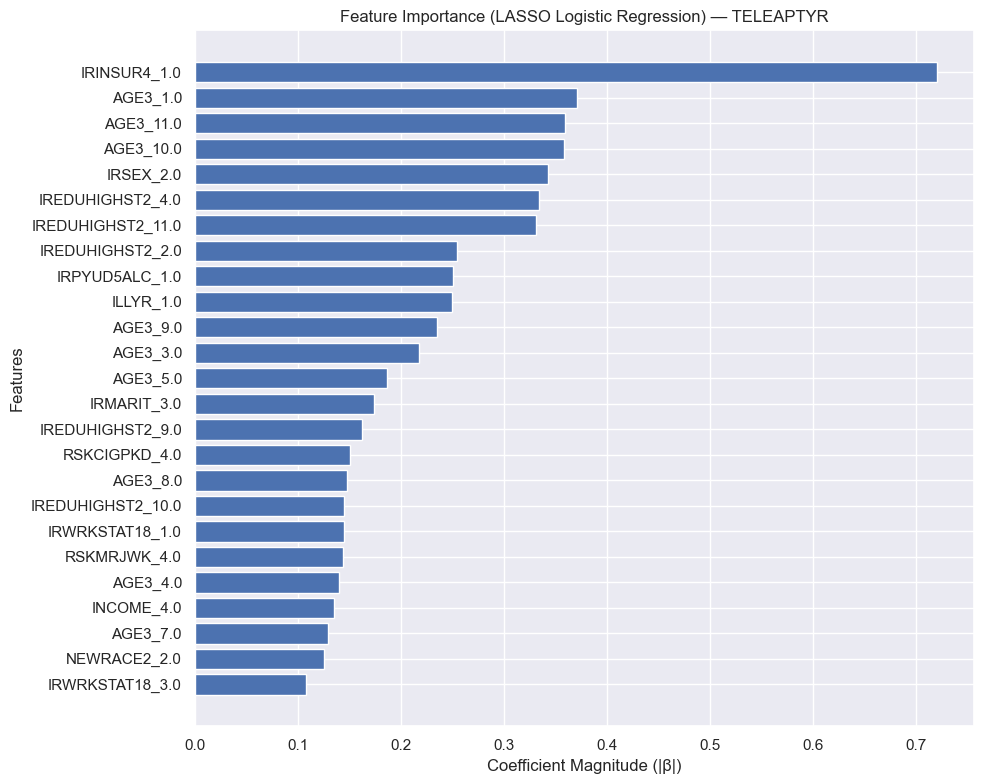

In [94]:
target = "TELEAPTYR" 
coef_path = os.path.join(outdir + "/TELEAPTYR/lasso_output/", f"lasso_{target}_coefficients.csv")
top_n = 25           # number of features to display

coef_df = pd.read_csv(coef_path)

# Clean and prepare
coef_df = coef_df.rename(columns={"feature": "Feature", "coef": "Coefficient"})
coef_df["AbsCoef"] = coef_df["Coefficient"].abs()

# Sort by absolute magnitude (descending)
coef_df = coef_df.sort_values(by="AbsCoef", ascending=False, ignore_index=True)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(coef_df["Feature"].head(top_n), coef_df["AbsCoef"].head(top_n)) 
plt.xlabel("Coefficient Magnitude (|β|)")
plt.ylabel("Features")
plt.title(f"Feature Importance (LASSO Logistic Regression) — {target}")
plt.gca().invert_yaxis()  
plt.tight_layout()

save_path = os.path.join(outdir_graph, f"lasso_{target}_feature_importance_from_export.png")
plt.savefig(save_path, dpi=200)
plt.show()

#### 4.8. Logistic Regression Model for TELEAPTYR using variables captured by LASSO

In [97]:
target = "TELEAPTYR"
weight = "ANALWT2_C"

# Top 10 LASSO predictors
top_lasso_features = [
    "IRSEX", "IRINSUR4", "ILLYR", "IRPYUD5ALC", "IRPYUD5MRJ",
    "KSSLR6YR", "NEWRACE2", "IRMARIT", "IREDUHIGHST2", "IRWRKSTAT18"
]
core_demo = ["INCOME", "POVERTY3"]

selected_features = list(dict.fromkeys(top_lasso_features + core_demo))

print("Variables included in MHTRTPY model:")
for v in selected_features:
    print("-", v)

# Prepare data
work = df.loc[df[target].notna() & df[weight].notna(), [target, weight] + selected_features].copy()
work[target] = pd.to_numeric(work[target], errors="coerce")
work[weight] = pd.to_numeric(work[weight], errors="coerce")

# Numeric vs categorical
numeric_cols = ["KSSLR6YR"]
categorical_cols = [c for c in selected_features if c not in numeric_cols]

# Median impute numeric
for c in numeric_cols:
    med = pd.to_numeric(work[c], errors="coerce").median()
    work[c] = pd.to_numeric(work[c], errors="coerce").fillna(med)

# Dummy encoding (explicit Missing category)
X_parts = []
for c in categorical_cols:
    work[c] = work[c].astype("category").cat.add_categories("Missing").fillna("Missing")
    dummies = pd.get_dummies(work[c], prefix=c, drop_first=True)
    X_parts.append(dummies)

X_cat = pd.concat(X_parts, axis=1)
X_num = work[numeric_cols]
X = pd.concat([X_cat, X_num], axis=1)

# Clean dtypes
X = X.apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan)
y = pd.to_numeric(work[target], errors="coerce")
w = pd.to_numeric(work[weight], errors="coerce")

keep = X.notna().all(axis=1) & y.notna() & w.notna()
X = X.loc[keep]
y = y.loc[keep]
w = w.loc[keep]

# Drop constants/duplicates
X = X.loc[:, X.nunique(dropna=False) > 1]
X = X.loc[:, ~X.T.duplicated()]

# Add constant
X = sm.add_constant(X).astype(float)
y = y.astype(float)
w = w.astype(float)

# Fit weighted logistic regression (robust SEs)
N = len(w)
w_freq = w * (N / w.sum())   # scaled so sum(weights) == N

print(f"\nModel fitting on {N:,} observations, {X.shape[1]} predictors.")
print("sum(freq_weights) =", w_freq.sum())
print("rank(X) vs cols:", np.linalg.matrix_rank(X.values), X.shape[1])

model = sm.GLM(y, X, family=sm.families.Binomial(), freq_weights=w_freq).fit(cov_type="HC1")
print(model.summary())

# Compute Odds Ratios with 95% CI
ci = model.conf_int()
ci.columns = ["2.5%", "97.5%"]
or_table = pd.DataFrame({
    "OR": np.exp(model.params),
    "2.5%": np.exp(ci["2.5%"]),
    "97.5%": np.exp(ci["97.5%"]),
    "p-value": model.pvalues
}).sort_values("OR", ascending=False)

print("\nTop predictors by OR:")
print(or_table.head(15))
print("\nLowest predictors by OR:")
print(or_table.tail(15))

# Save text summary 
with open(os.path.join(outdir + "/TELEAPTYR/glm_output/", f"glm_{target}_summary.txt"), "w") as f:
    f.write(model.summary().as_text())

# Save full OR table
or_table.to_csv(os.path.join(outdir + "/TELEAPTYR/glm_output/", f"glm_{target}_or_table.csv"))

# Save compact (manuscript-ready) table
nice = or_table.copy()
nice["OR (95% CI)"] = nice.apply(lambda r: f'{r["OR"]:.2f} ({r["2.5%"]:.2f}, {r["97.5%"]:.2f})', axis=1)
nice = nice[["OR (95% CI)", "p-value"]]
nice.to_csv(os.path.join(outdir + "/TELEAPTYR/glm_output/", f"glm_{target}_or_table_compact.csv"))

Variables included in MHTRTPY model:
- IRSEX
- IRINSUR4
- ILLYR
- IRPYUD5ALC
- IRPYUD5MRJ
- KSSLR6YR
- NEWRACE2
- IRMARIT
- IREDUHIGHST2
- IRWRKSTAT18
- INCOME
- POVERTY3

Model fitting on 55,622 observations, 37 predictors.
sum(freq_weights) = 55622.0
rank(X) vs cols: 37 37
                 Generalized Linear Model Regression Results                  
Dep. Variable:              TELEAPTYR   No. Observations:                55622
Model:                            GLM   Df Residuals:                    55585
Model Family:                Binomial   Df Model:                           36
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -31929.
Date:                Sun, 19 Oct 2025   Deviance:                       63859.
Time:                        23:57:48   Pearson chi2:                 5.56e+04
No. Iterations:                     6   Pseudo R-squ. (CS):            0.04208
Covariance Ty

#### 4.9. Random Forest Model for TELEAPTYR 


 Random Forest results for TELEAPTYR:
AUC (weighted): 0.614
Accuracy (weighted, thr=0.5): 0.719


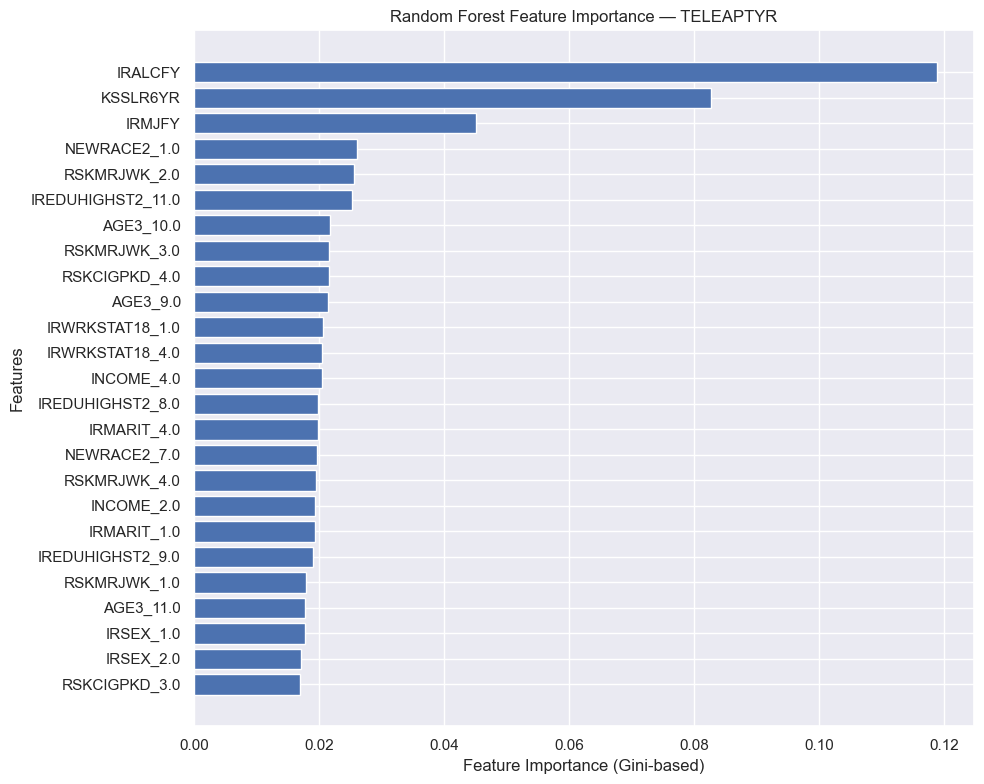

In [95]:
target = "TELEAPTYR"   
weight = "ANALWT2_C"

numeric_cols = ["IRALCFY", "IRMJFY", "KSSLR6YR"]

categorical_cols = [
    "AGE3","IRSEX","NEWRACE2",
    "IRMARIT","IREDUHIGHST2","IRWRKSTAT18",
    "IRINSUR4","INCOME","POVERTY3",
    "IRPYUD5ALC","IRPYUD5MRJ","ILLYR",
    "RSKCIGPKD","RSKMRJWK"
]

work = df.loc[df[target].notna() & df[weight].notna()].copy()
work["w_norm"] = work[weight] / work[weight].mean()

X = work[categorical_cols + numeric_cols]
y = work[target].astype(int).to_numpy().ravel()
w = work["w_norm"].astype(float).to_numpy().ravel()

# Train-test split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w, test_size=0.25, random_state=123, stratify=y
)

# Preprocessing
pre = ColumnTransformer(
    transformers=[
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), categorical_cols),
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_cols),
    ],
    remainder="drop"
)

# Random Forest
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=123,
    n_jobs=-1,
    class_weight=None  
)

pipe_rf = Pipeline([
    ("pre", pre),
    ("clf", rf)
])

pipe_rf.fit(X_train, y_train, clf__sample_weight=w_train)

# Evaluate
y_prob = pipe_rf.predict_proba(X_test)[:, 1]
y_hat  = (y_prob >= 0.5).astype(int)

auc = roc_auc_score(y_test, y_prob, sample_weight=w_test)
acc = accuracy_score(y_test, y_hat, sample_weight=w_test)

print(f"\n Random Forest results for {target}:")
print(f"AUC (weighted): {auc:.3f}")
print(f"Accuracy (weighted, thr=0.5): {acc:.3f}")

metrics = {
    "target": target,
    "AUC_weighted": float(auc),
    "Accuracy_weighted_thr0.5": float(acc),
    "N_train": len(y_train),
    "N_test": len(y_test)
}

# Save metrics JSON
with open(os.path.join(outdir + "/TELEAPTYR/rf_output/", f"rf_{target}_metrics.json"), "w") as f:
    json.dump(metrics, f, indent=2)

# Feature Importance
# Get feature names after preprocessing
cat_names = pipe_rf.named_steps["pre"].named_transformers_["cat"].named_steps["ohe"].get_feature_names_out(categorical_cols)
feature_names = list(cat_names) + numeric_cols

importances = pipe_rf.named_steps["clf"].feature_importances_
imp_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
imp_df = imp_df.sort_values("Importance", ascending=False)

imp_df.to_csv(os.path.join(outdir + "/TELEAPTYR/rf_output/", f"rf_{target}_feature_importance.csv"), index=False)

# Plot & Export
top_n = 25
plt.figure(figsize=(10, 8))
plt.barh(imp_df["Feature"].head(top_n), imp_df["Importance"].head(top_n))
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance (Gini-based)")
plt.ylabel("Features")
plt.title(f"Random Forest Feature Importance — {target}")
plt.tight_layout()

plt.savefig(os.path.join(outdir_graph, f"rf_{target}_feature_importance.png"), dpi=200)
plt.show()